# CAICT 風機結冰預測 - Data Exploration 

 ### 2017/08/04
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

In [290]:
from IPython.display import HTML
HTML('''<script>
presentation = 1;
code_show=true; 
function code_toggle() {
 if (!presentation){
     return;
 }
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')


<a id='home'></a>
### Outline
[1. Modules](#load)  
[2. Input Data](#input)  
[3. Single Variable Exploration](#single)    
[4. Multi-Variable Exploration](#multi)
[5. dimension reduction](#dimen)

In [82]:
%matplotlib inline
import sys
import os
import datetime
import pandas as pd
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import shutil
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
from sklearn.decomposition import PCA
from sklearn import preprocessing
from mpl_toolkits import mplot3d
import scipy.stats as stats
import pylab
import plastid
from IPython.display import HTML
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,Lasso,Ridge
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

In [301]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled


def load_resample_data(mid, policy=1,  ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    print('load file:',filename)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)

    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_resample_data_passonly(mid, policy=1, ycol='label'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample = data_resample[data_resample['label']==0]
    data_resample=data_resample.dropna()
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_X = data_X.drop([ycol], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_resample_data_split(mid, split_case, policy=1, ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)
    #data_resample = data_resample[data_resample['label']!=2]
    #data_resample=data_resample.dropna()
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1)
    train_X = train_X.drop([ycol], axis=1)
    train_y = data_resample_train[ycol]
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1)
    valid_X = valid_X.drop([ycol], axis=1)
    valid_y = data_resample_valid[ycol]
    train_Y = np.eye(train_y.unique().size)[train_y.values.astype(int)]
    valid_Y = np.eye(valid_y.unique().size)[valid_y.values.astype(int)]
    return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y

def load_test2_data():
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group'], axis=1)
    test_X = tmp
    return test_data, test_X, test_timeidx

def load_traindata_puwercurve_analysis(mid=15,policy=0):
    non_data_cols = ['label','time','group','timestamp','event']
    data_raw, data_X, _, _ = load_resample_data(mid=mid,policy=policy)
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled

def load_testdata_puwercurve_analysis():
    non_data_cols = ['time','group']
    data_raw, data_X, _ = load_test2_data()
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled

In [379]:
color_ewma={'power':'blue', 'wind_speed':'darkorange'}
color_rollstd={'power':'darkorchid', 'wind_speed':'darkorchid'}
color_predewma={'power':'chartreuse'}
color_predmadiffsum={'power':'black'}

def trend_chart_combine(data, event_id, varlist=['label'], ma=50):
    if type(event_id) is int:
        event_id=[event_id]
    #print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        #evtdata_abnor=evtdata[evtdata['label']==1]
        fail_timestamp = evtdata[evtdata['label']==1]['timestamp'].iloc[0]
        try:
            unknown_timestamp = evtdata[evtdata['label']==2]['timestamp'].iloc[0]
        except:
            unknown_timestamp=None
            
        dummy = plt.figure(figsize=[17,2])
        for var in varlist:
            dummy = plt.plot(evtdata['timestamp'],pd.ewma(evtdata[var], halflife=ma),lw=1.2, color=color_ewma.get(var), label= var+'(ewma)')
        plt.axvline(fail_timestamp, color='r', linestyle='dashed', lw=0.5)
        if unknown_timestamp:
            plt.axvline(unknown_timestamp, color='b', linestyle='dashed', lw=0.5)
        plt.legend(loc='upper left')
        plt.title('event '+str(eid)+'\t'+str(varlist))
        plt.show()
    

def trend_chart_pred(data, event_id, varlist=['label'], ma=50):
    if type(event_id) is int:
        event_id=[event_id]
    #print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        #evtdata_abnor=evtdata[evtdata['label']==1]
        fail_timestamp = evtdata[evtdata['label']==1]['timestamp'].iloc[0]
        try:
            unknown_timestamp = evtdata[evtdata['label']==2]['timestamp'].iloc[0]
        except:
            unknown_timestamp=None
        dummy = plt.figure(figsize=[17,2])
        for var in varlist:
            dummy = plt.plot(evtdata['timestamp'],pd.ewma(evtdata[var], halflife=ma),lw=1.2, label= var+'(ewma)',color=color_ewma.get(var))
        
        dummy = plt.plot(evtdata['timestamp'],pd.ewma(evtdata['pred'], halflife=ma),lw=1.2, label= 'power pred(ewma)', color=color_predewma.get('power') )
        dummy = plt.plot(evtdata['timestamp'],pd.rolling_std(evtdata['power'],ma) ,lw=0.8, label='power rolling_std',  color=color_rollstd.get('power'))
        
        #dummy = plt.plot(evtdata['timestamp'],pd.rolling_sum(evtdata['perd_diff'],ma) ,lw=0.8, label='power pred diffsum')
        dummy = plt.plot(evtdata['timestamp'],evtdata['perd_madiff'] ,lw=0.8, label='power pred madiffsum', color=color_predmadiffsum.get('power'))
        
        plt.axvline(fail_timestamp, color='r', linestyle='dashed', lw=0.5)
        if unknown_timestamp:
            plt.axvline(unknown_timestamp, color='b', linestyle='dashed', lw=0.5)
        plt.legend(loc='upper left')
        plt.title('event '+str(eid)+'\t'+str(varlist)+'\t'+'- Predition')
        plt.show()
        
def trend_chard_predlabel(data, event_id):
    if type(event_id) is int:
        event_id=[event_id]
    #print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        fail_timestamp = evtdata[evtdata['label']==1]['timestamp'].iloc[0]
        try:
            unknown_timestamp = evtdata[evtdata['label']==2]['timestamp'].iloc[0]
        except:
            unknown_timestamp=None
        dummy = plt.figure(figsize=[17,2])
        dummy = plt.plot(evtdata['timestamp'],evtdata['pred_label'],lw=1.2, label= 'predict', color='green' )
        dummy = plt.plot(evtdata['timestamp'],evtdata['label'],lw=1.2, label= 'label', color='black' )
        plt.axvline(fail_timestamp, color='r', linestyle='dashed', lw=0.5)
        if unknown_timestamp:
            plt.axvline(unknown_timestamp, color='b', linestyle='dashed', lw=0.5)
        plt.legend(loc='upper left')
        plt.title('event '+str(eid)+'\t'+'- label Predition')
        plt.show()    
    
    
    
def scatter_error(data,event_id):
    if type(event_id) is int:
        event_id=[event_id]
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        dummy = plt.figure(figsize=[17,5])
        plt.subplot(1,2,1)
        #plt.scatter('power_ewma', 'power_rollstd',marker='.', alpha=0.6, data=evtdata)
        plt.scatter('power_ewma', 'power_rollstd', c='label',  marker='.', alpha=0.6, data=evtdata,norm=norm, cmap=cmap)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title('event '+str(eid))
        plt.xlabel('power_ewma')
        plt.ylabel('power_rollstd')
        
        plt.subplot(1,2,2)
        plt.scatter('power_ewma', 'perd_madiff', c='label',  marker='.', alpha=0.6, data=evtdata,norm=norm, cmap=cmap)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title('event '+str(eid))
        plt.xlabel('power_ewma')
        plt.ylabel('perd_madiff')
        plt.show()    
        
        
def trend_chart(data, event_id, varlist=['label'], tsrange=None, split=False, ma=50):
    if type(event_id) is int:
        event_id=[event_id]
    #print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        if tsrange is not None:
            evtdata = evtdata[(evtdata['timestamp']>tsrange[0]) & (evtdata['timestamp']<tsrange[-1])]
        evtdata_nor=evtdata[evtdata['label']==0]
        evtdata_abnor=evtdata[evtdata['label']==1]
        evtdata_unknown=evtdata[evtdata['label']==2]

        for var in varlist:
            dummy = plt.figure(figsize=[17,2])
            dummy = plt.plot(evtdata_nor['timestamp'],evtdata_nor[var], color='green',marker='o',ms=1,label='pass')
            dummy = plt.plot(evtdata_unknown['timestamp'],evtdata_unknown[var], color='gray',marker='o',ms=1, label='unknown')
            dummy = plt.plot(evtdata_abnor['timestamp'],evtdata_abnor[var], color='red',marker='o',ms=1, label='fail')
            plt.title('event '+str(eid)+'\t'+var,fontsize='large')
            #dummy = plt.plot(evtdata['timestamp'],pd.rolling_mean(evtdata[var],ma), color='cyan',lw=0.8, label='ma')
            dummy = plt.plot(evtdata['timestamp'],pd.rolling_std(evtdata[var],ma), color=color_rollstd.get(var),lw=0.8, label='rolling_std')
            dummy = plt.plot(evtdata['timestamp'],pd.ewma(evtdata[var], halflife=ma), color=color_ewma.get(var),lw=0.8, label='ewma')
            #data_diff = evtdata[var] - evtdata[var].shift() 
            #dummy = plt.plot(evtdata['timestamp'],data_diff, color='cyan',lw=0.8, label='diff')
            plt.legend(loc='upper left')
            if split: 
                dummy = plt.figure(figsize=[17,2])
                dummy = plt.plot(evtdata_nor['timestamp'],evtdata_nor[var], color='green',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'normal')
                dummy = plt.figure(figsize=[17,2])
                dummy = 0 if evtdata_unknown.empty else plt.plot(evtdata_unknown['timestamp'],evtdata_unknown[var], color='gray',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'unknown')
                dummy = plt.figure(figsize=[17,2])
                dummy = plt.plot(evtdata_abnor['timestamp'],evtdata_abnor[var], color='red',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'failure')
        dummy = plt.show()



In [351]:
def scatter_plot(data, event_id, varx, varylist):
    if type(event_id) is int:
        event_id=[event_id]
    varsize = len(varylist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        dummy = plt.figure(figsize=[17,5])
        for idx, vary in enumerate(varylist):
            plt.subplot(1,varsize,idx+1)
            plt.scatter(varx, vary, c='label', edgecolor='gray', marker='.', alpha=0.6, data=evtdata,norm=norm, cmap=cmap)
            
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.title('event '+str(eid))
            plt.xlabel(varx)
            plt.ylabel(vary)
        #plt.tight_layout()
        plt.show()

def sactter_3d(data, event_id, varx, vary, varzlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varzlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        dummy = plt.figure(figsize=[15,5])
        for idx, varz in enumerate(varzlist):
            #plt.figure(figsize=[10,8])
            ax = plt.subplot(1,varsize,idx+1, projection='3d')
            ax.scatter3D(evtdata[varx],evtdata[vary],evtdata[varz],c=evtdata['label'], cmap=cmap, norm=norm)
            ax.set_xlabel(varx)
            ax.set_ylabel(vary)
            ax.set_zlabel(varz)
            plt.title('event:'+str(eid))
        plt.show()

In [364]:
#rfe = RFE(xgb.XGBRegressor(), 1)
def feature_selection(data, event_id, predY='power', estimator=xgb.XGBRegressor()):
    evtdata = data[data['event']==event_id]
    rfe = RFE(estimator, 1)
    #train_x = evtdata.drop(['label','time','group','timestamp','event'], axis=1)
    train_x = evtdata[modeling_feature]
   # if predY in train_x.columns:
   #     train_x = train_x.drop([predY], axis=1)
    train_y = evtdata[predY]
    fit = rfe.fit(train_x,train_y)
    feature_imp = pd.DataFrame(list(zip(train_x.columns, np.transpose(fit.ranking_))), columns=['feature','ranking'])
    feature_imp = feature_imp.sort_values(by='ranking', ascending=True).reset_index(drop=True)
    print('feature importance, predict:',predY)
    return feature_imp



In [ ]:
def perdict_label(data_train. data_predict):
    train_x_2 = data_train[modeling_feature]
    train_x_2['pred_power']=model_xgb.predict(train_x_2.values)
    train_x_2['power']=data_trained['power']
    train_y_2 = data_trained['label']
    model_xgb_2 = xgb.XGBRegressor()
    model_xgb_2 = model_xgb_2.fit(train_x_2.values, train_y_2.values)
    predict_x_2 = data_pred[modeling_feature]
    predict_x_2['pred_power']=model_xgb.predict(predict_x_2.values)
    predict_x_2['power']=data_pred['power']
    pred_y_2 = model_xgb_2.predict(predict_x_2.values)
    
    
    

<a id='input'></a>
** Input Data **

In [377]:
def exploration(data_trained, data_pred, ma):
    #predict power
    data_trained_Pass = data_trained[data_trained['label']==0]
    train_x = data_trained_Pass[modeling_feature]
    train_y = data_trained_Pass['power']
    model_xgb = xgb.XGBRegressor()
    model_xgb = model_xgb.fit(train_x.values, train_y.values)
    predict_x = data_pred[modeling_feature]
    pred_y = model_xgb.predict(predict_x.values)
    
    #predict label
    train_x_2 = data_trained[modeling_feature]
    train_x_2['pred_power']=model_xgb.predict(train_x_2.values)
    train_x_2['power']=data_trained['power']
    train_y_2 = data_trained['label']
    model_xgb_2 = xgb.XGBRegressor()
    model_xgb_2 = model_xgb_2.fit(train_x_2.values, train_y_2.values)
    predict_x_2 = data_pred[modeling_feature]
    predict_x_2['pred_power']=model_xgb.predict(predict_x_2.values)
    predict_x_2['power']=data_pred['power']
    pred_y_2 = model_xgb_2.predict(predict_x_2.values)
    
    
    ma=50
    eventlist= data_pred['event'].unique()
    eventlist=eventlist.astype(int)
    data_pred_tmp =data_pred[['event', 'label', 'timestamp', 'power', 'wind_speed']]
    data_pred_tmp['pred'] = pred_y
    data_pred_tmp['perd_diff']= abs(data_pred_tmp['pred'] - data_pred_tmp['power'])
    data_pred_tmp['perd_madiff']= abs(pd.rolling_mean(data_pred_tmp['pred'], ma) - pd.rolling_mean(data_pred_tmp['power'],ma)) 
    data_pred_tmp['power_ewma']=pd.ewma(data_pred_tmp['power'], halflife = ma)
    data_pred_tmp['power_rollstd']=pd.rolling_std(data_pred_tmp['power'], ma)
    data_pred_tmp['pred_label'] = pred_y_2
        
    feature_imp_dict={}
    for e in eventlist:
        HTML('''<HR>''')
        print('event id:', e)
        e = int(e)
        feature_imp = feature_selection(dat_scaled_M15,event_id=e)
        feature_imp_dict[e]=feature_imp['feature'].values
        
        #print(feature_imp)
        trend_chart(data_pred, e,varlist=['power','wind_speed'], ma=50)
        trend_chart_combine(data_pred, e,varlist=['power','wind_speed'], ma=50)
        trend_chart_pred(data_pred_tmp, e, varlist=['power'], ma=50)
        trend_chard_predlabel(data_pred_tmp, e)
        
        scatter_plot(data_pred, event_id=e, varx='wind_speed', varylist=['power','generator_speed'])
        scatter_error(data_pred_tmp, event_id=e)
        #scatter_plot(data_pred, event_id=e, vary='generator_speed', varxlist=['wind_speed','power'])
        #sactter_3d(data_pred, event_id=e, varx='environment_tmp', vary='wind_speed', varzlist=['power','generator_speed'])
    print(pd.DataFrame(feature_imp_dict))


data resample policy
- policy=0: no resample
- policy=1: event data + normal data (before and after event )
- policy=2: half event data + normal data (before event only)  
- policy=3: event data + normal data (before event only) 
- policy=4: event data + 2*normal data (before event only) 

for each event
- feature trend chart
- scatter plot
- power prediction trend chart
- motospeed prediction trend chart
- feature selection by RFE

***

** Exploration 1 **
- Training Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 0  
- Prediction Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 4

In [314]:
data_raw_M15_Complete, dat_scaled_M15_Complete = load_traindata_puwercurve_analysis(mid=15,policy=0)
data_raw_M15, dat_scaled_M15 = load_traindata_puwercurve_analysis(mid=15,policy=4)

modeling_feature = ['wind_speed', 'generator_speed', 'wind_direction','wind_direction_mean', 'yaw_position', 'yaw_speed', 
 'pitch1_angle', 'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed','pitch3_speed', 
 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp', 'acc_x', 'acc_y', 'environment_tmp', 
 'int_tmp', 'pitch1_ng5_tmp', 'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC','pitch3_ng5_DC']


load file: data/resample_data_p0_15.csv
load file: data/resample_data_p4_15.csv


event id: 0
feature importance, predict: power


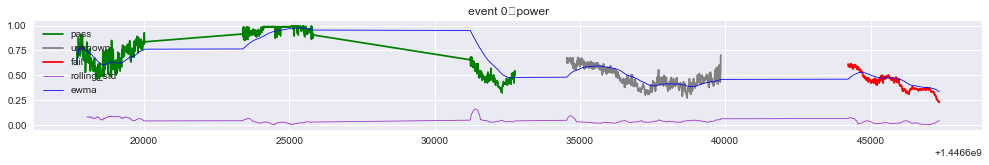

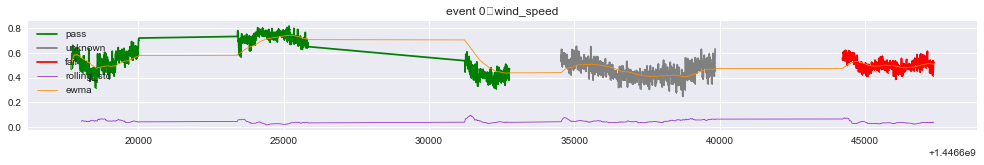

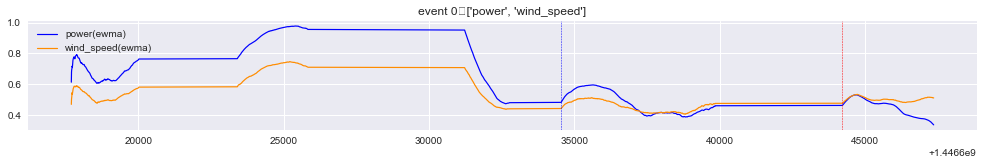

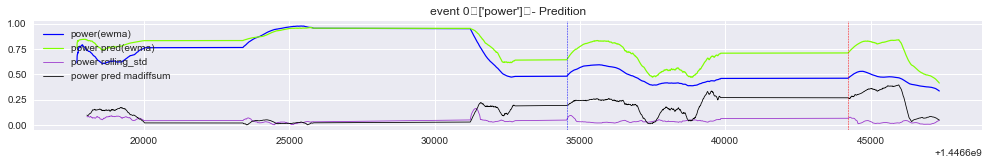

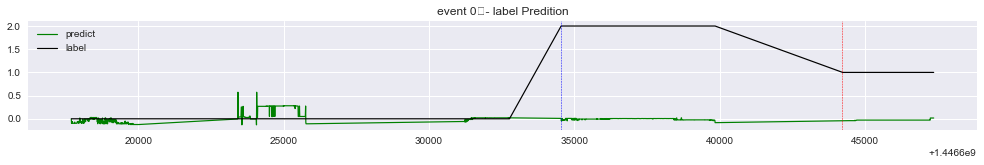

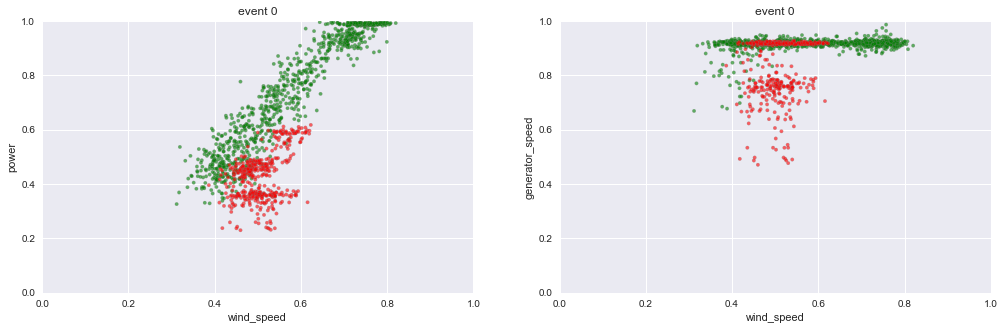

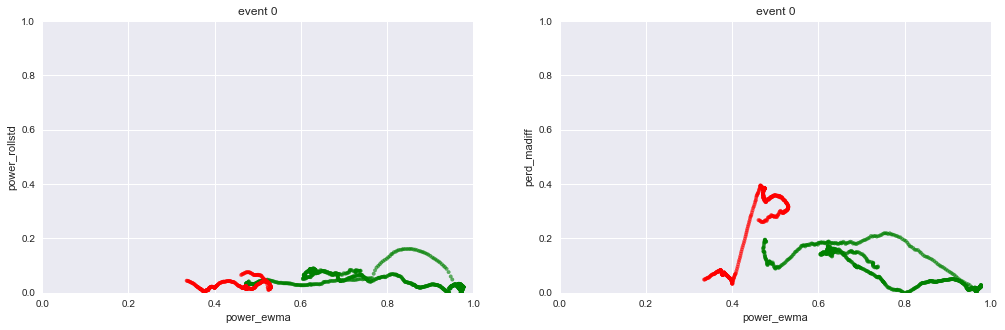

event id: 1
feature importance, predict: power


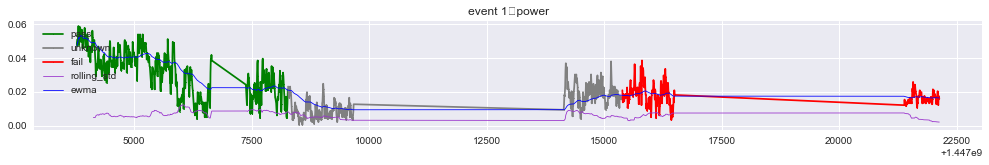

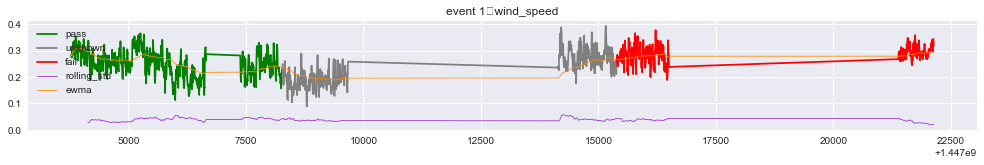

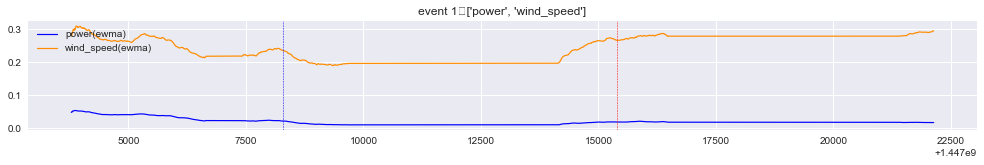

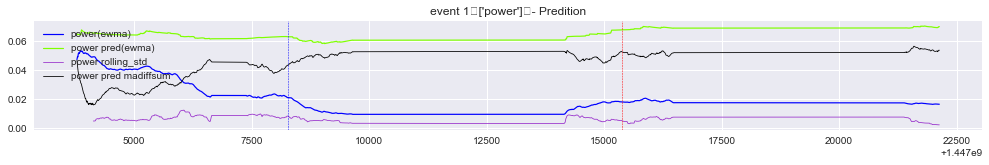

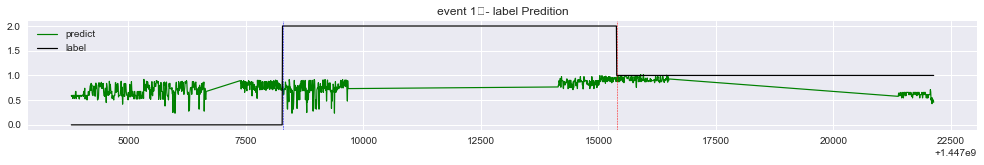

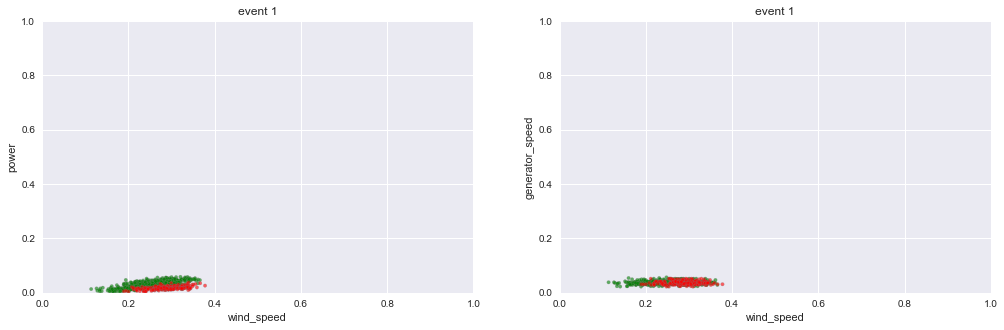

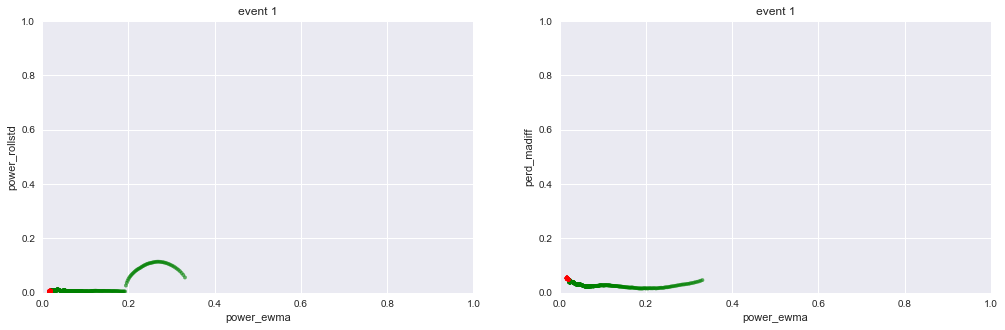

event id: 2
feature importance, predict: power


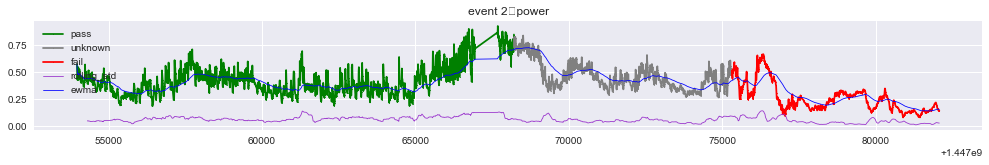

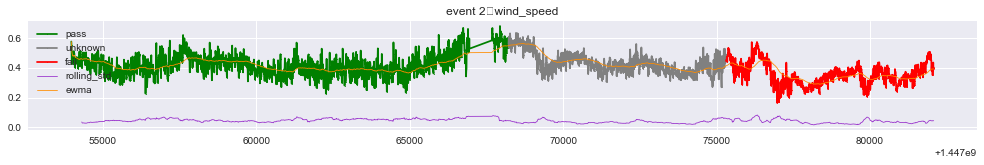

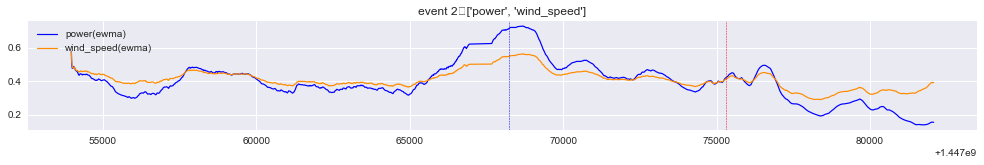

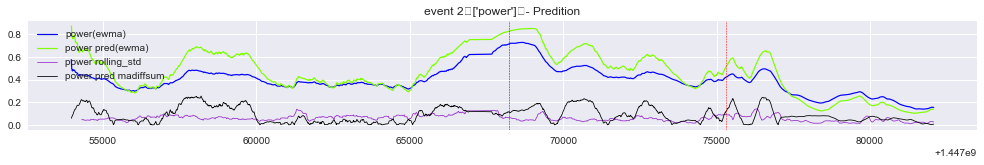

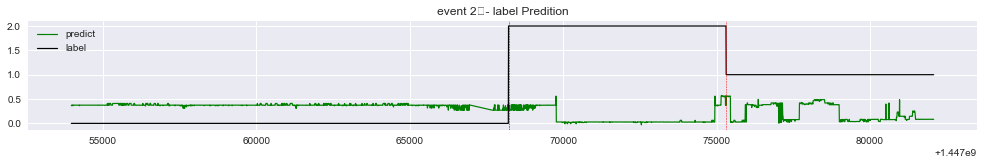

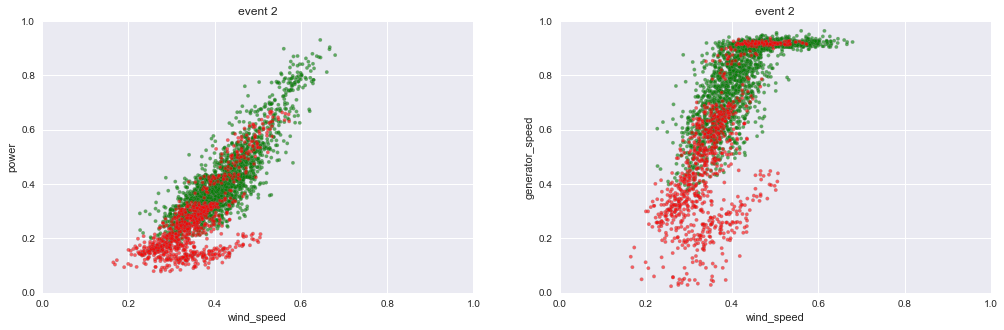

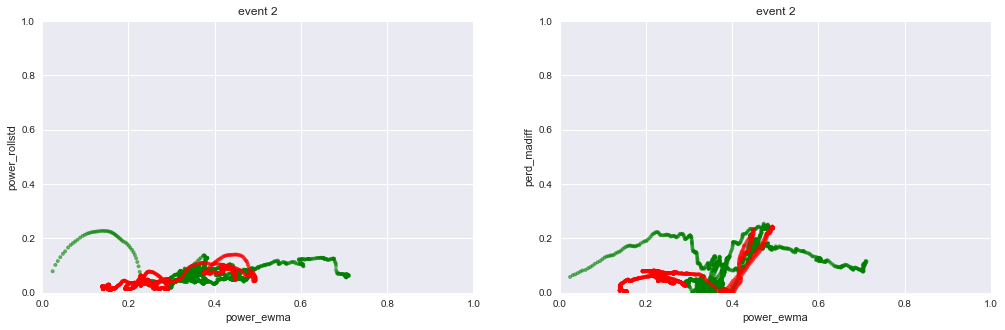

event id: 3
feature importance, predict: power


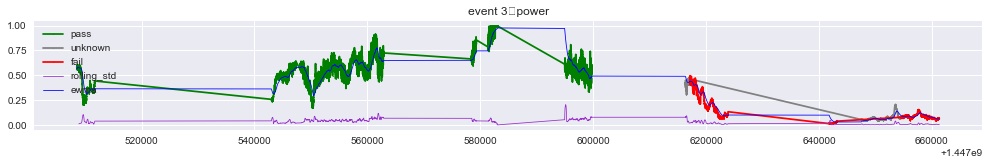

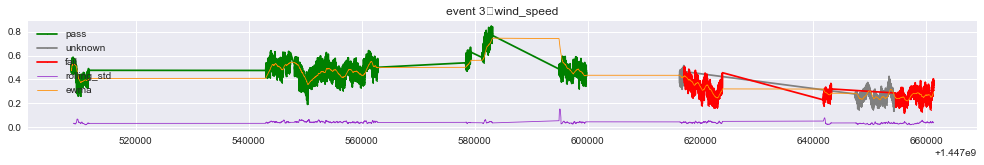

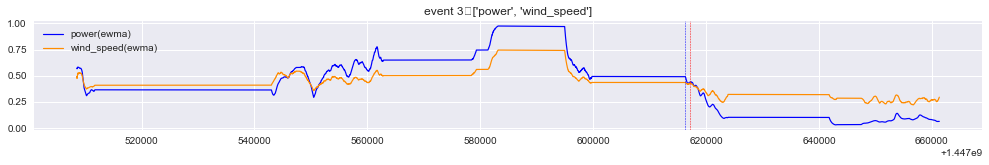

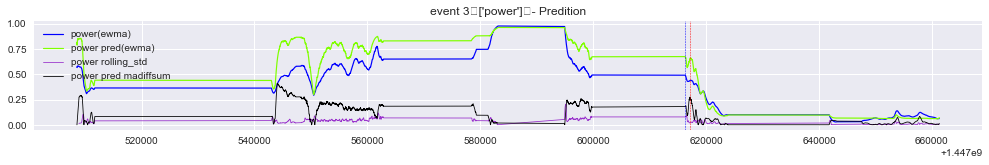

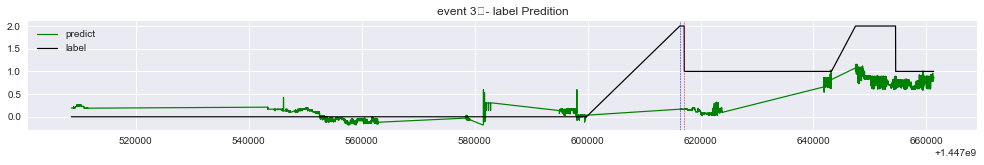

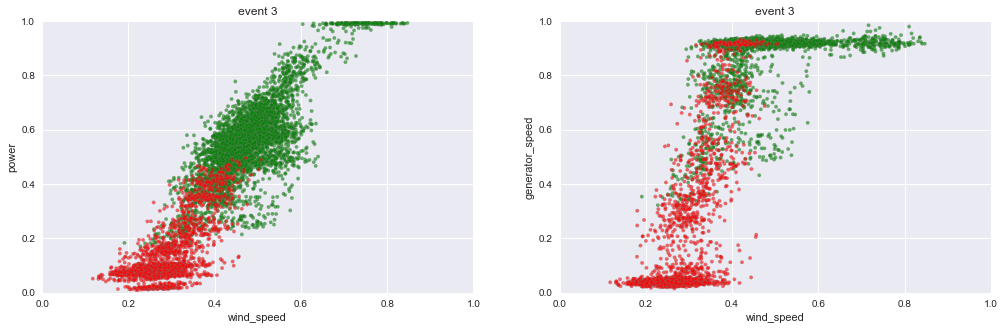

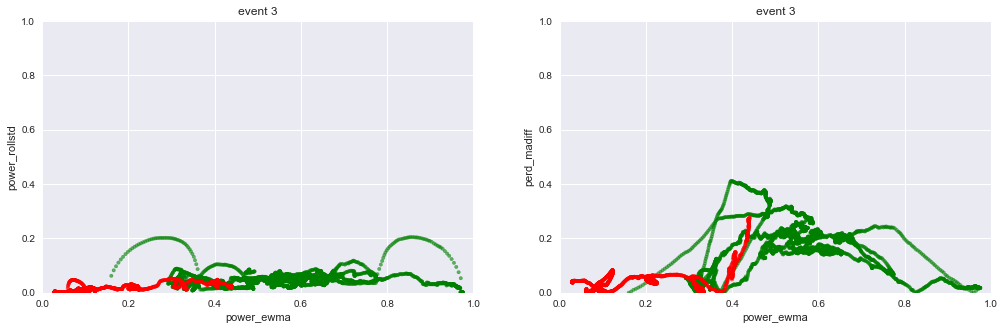

event id: 4
feature importance, predict: power


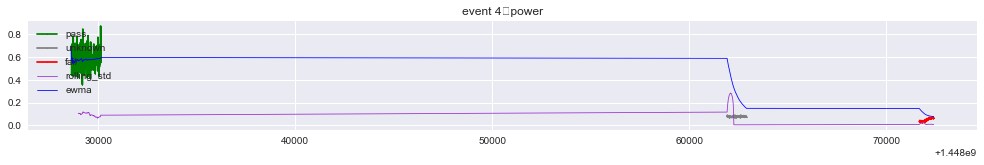

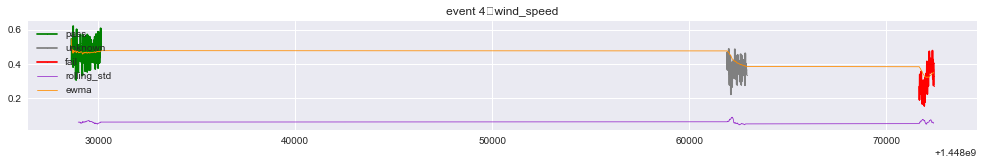

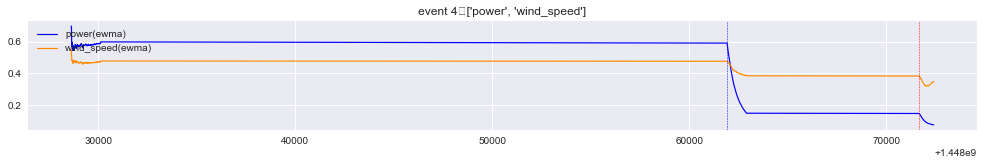

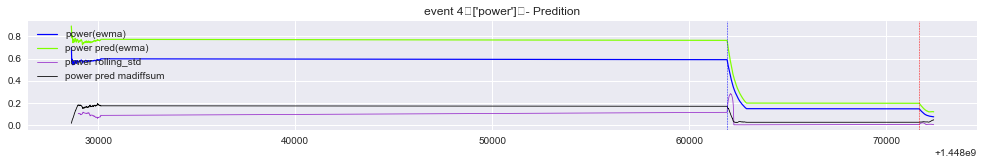

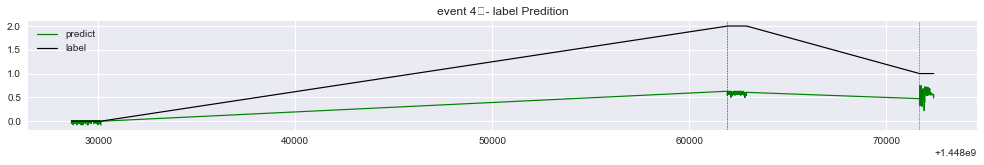

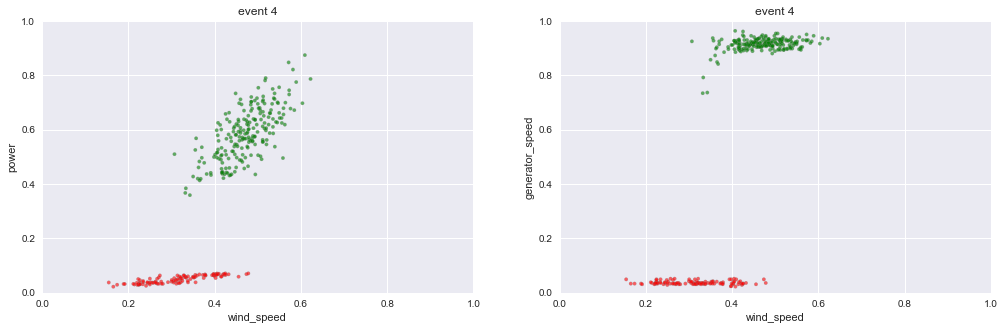

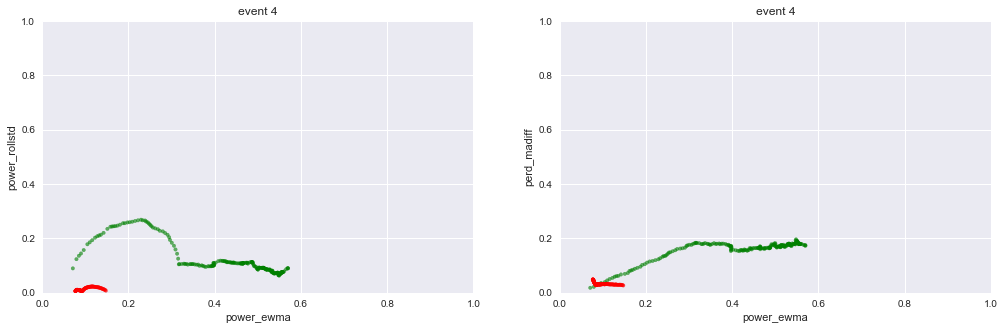

event id: 5
feature importance, predict: power


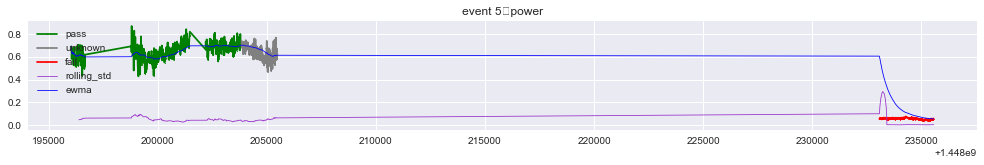

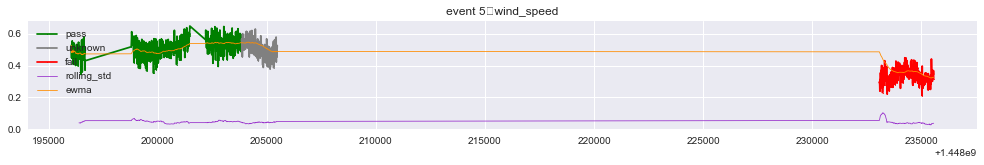

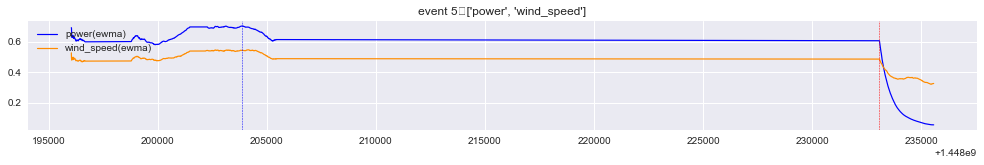

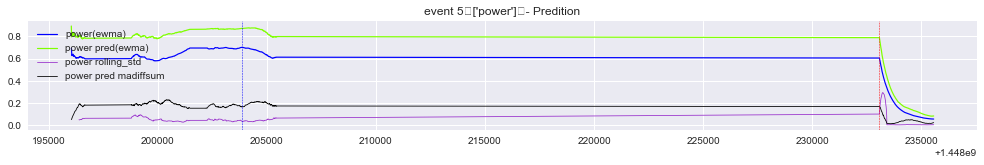

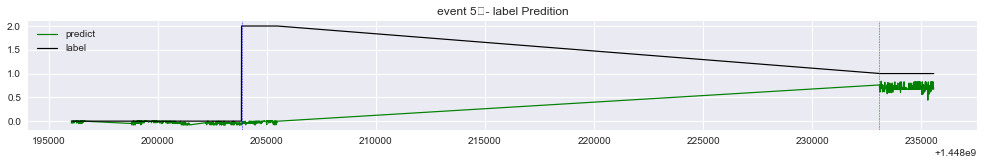

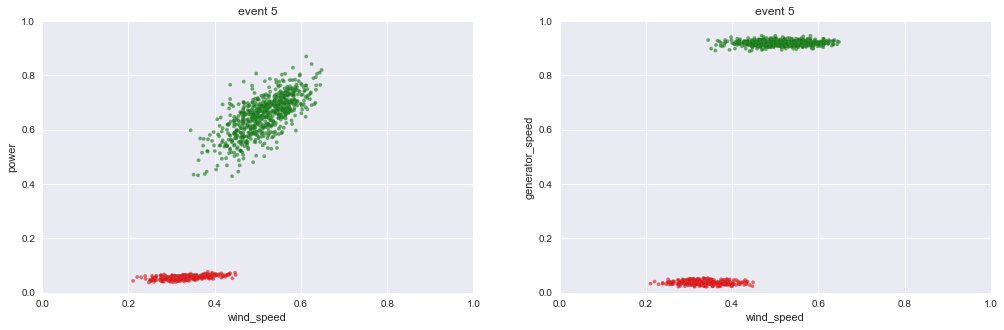

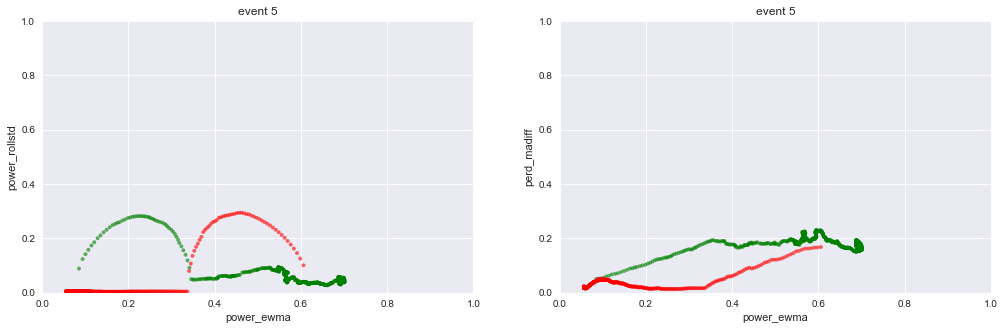

event id: 6
feature importance, predict: power


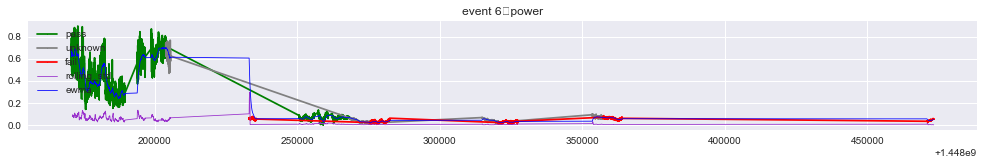

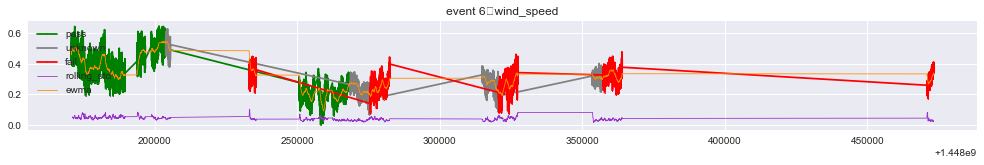

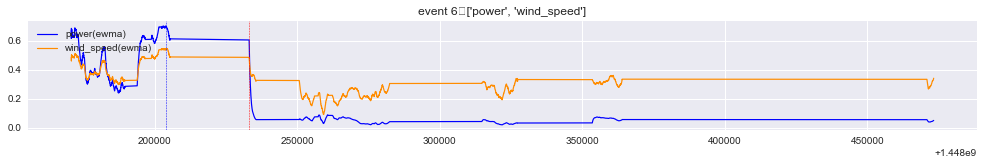

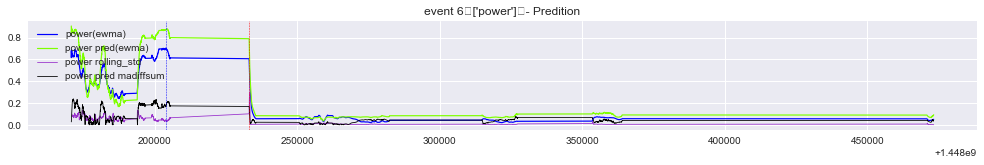

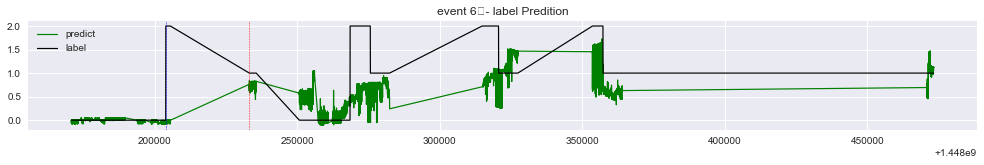

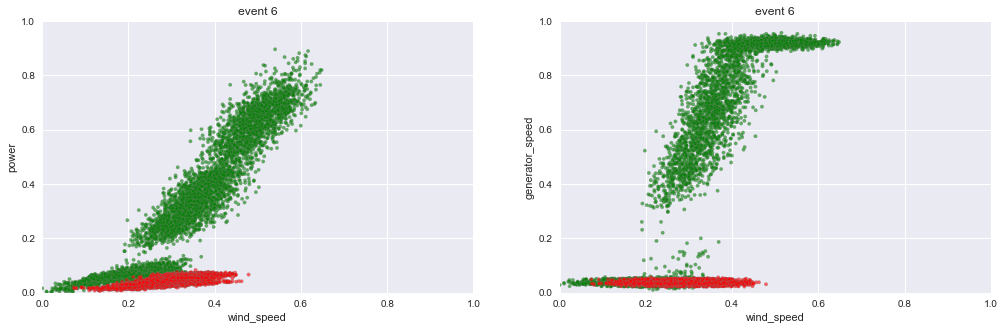

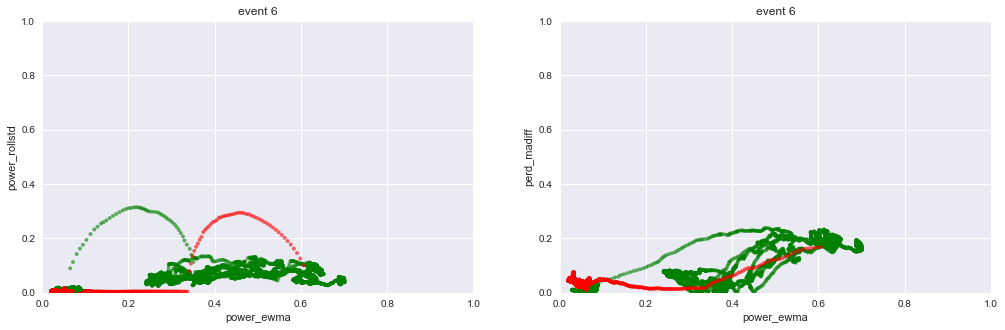

event id: 7
feature importance, predict: power


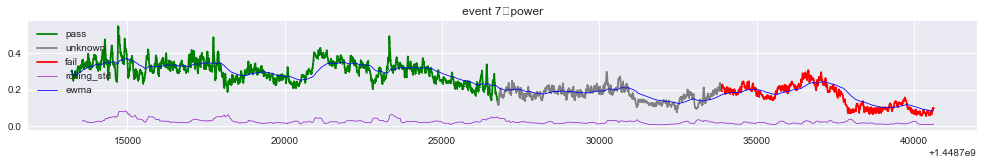

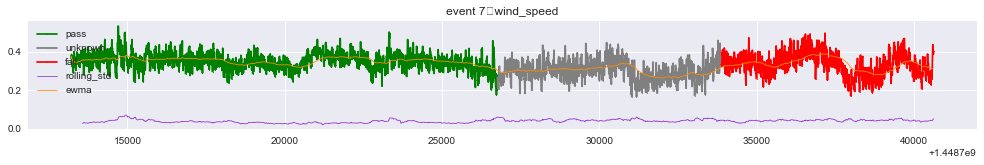

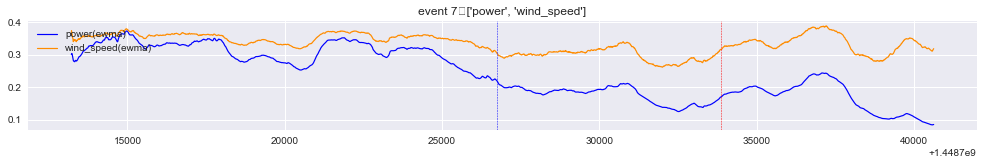

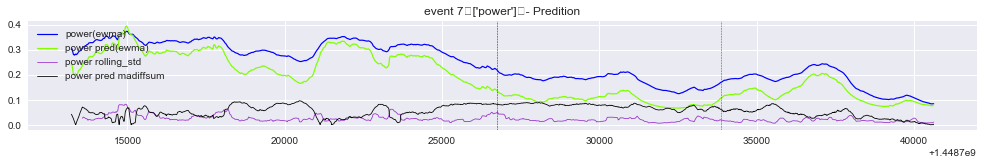

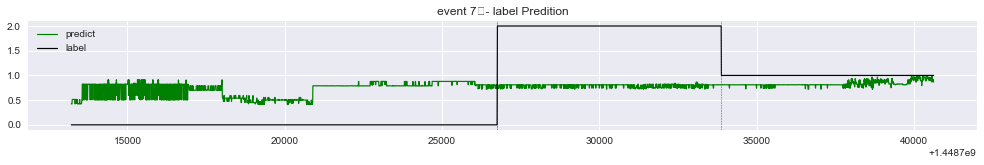

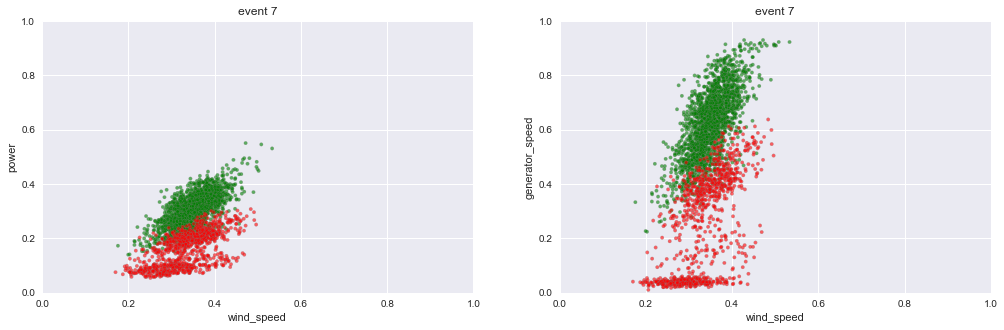

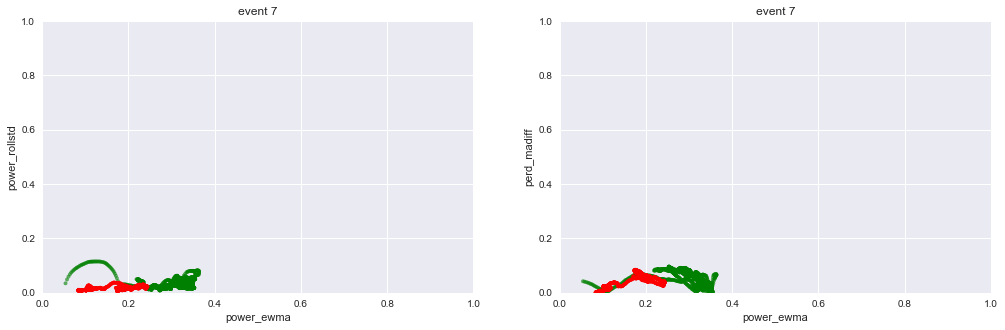

event id: 8
feature importance, predict: power


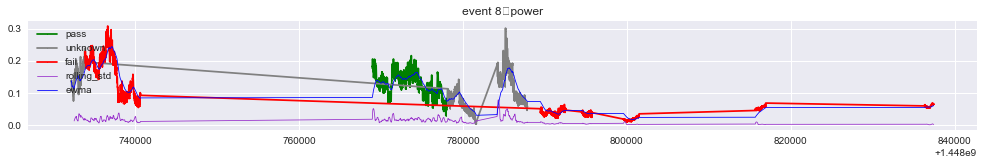

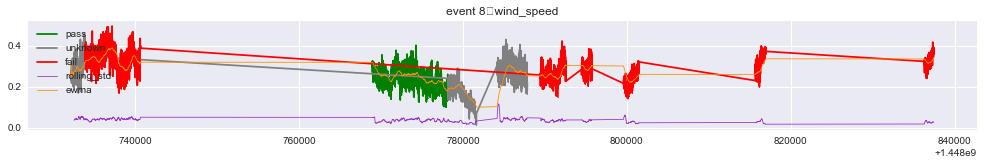

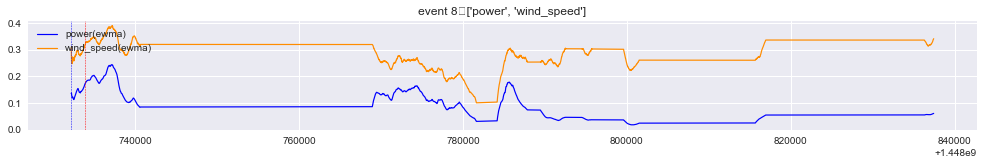

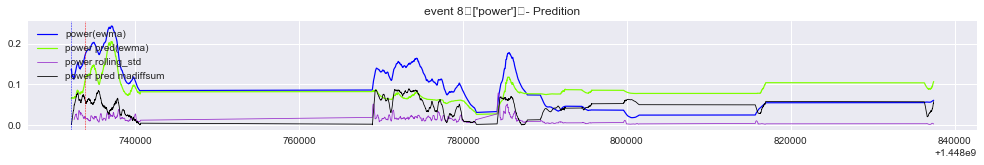

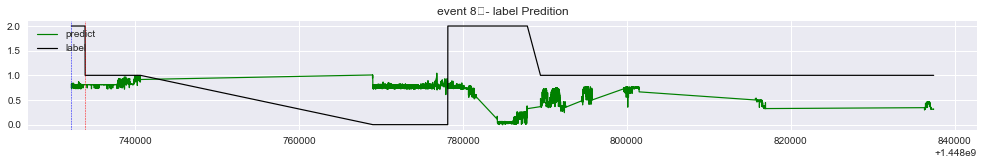

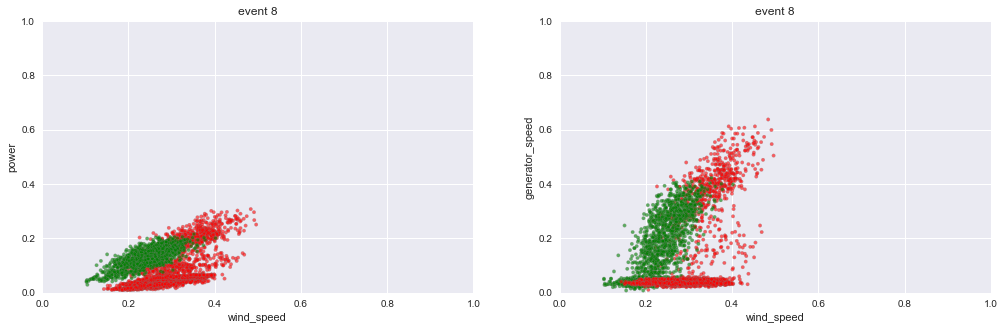

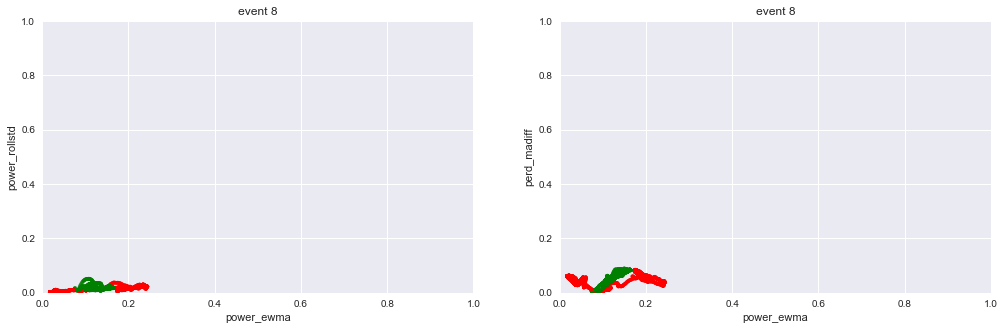

event id: 9
feature importance, predict: power


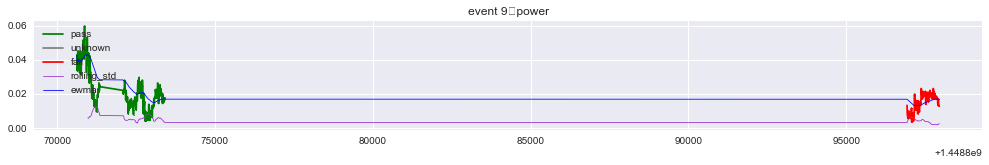

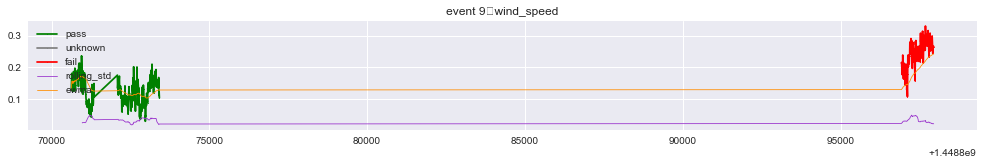

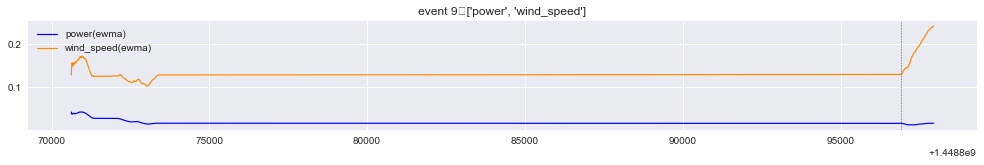

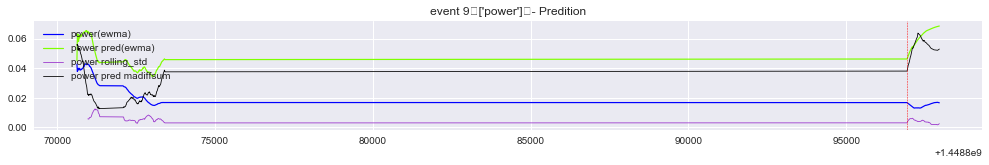

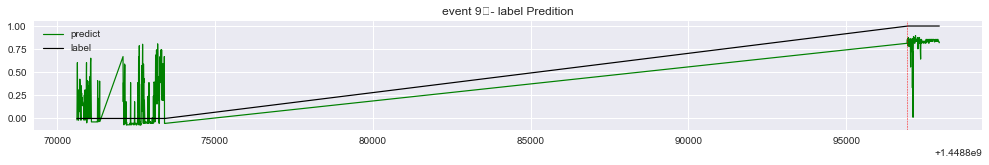

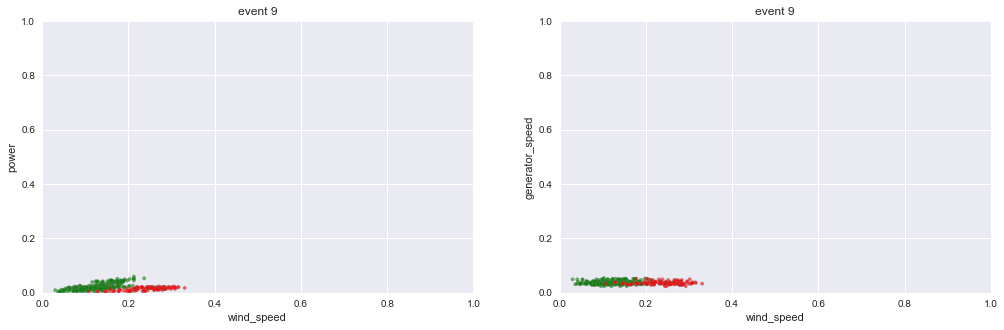

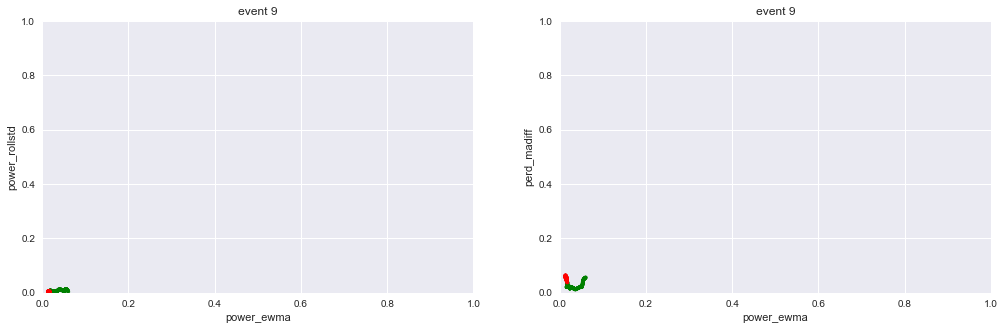

event id: 10
feature importance, predict: power


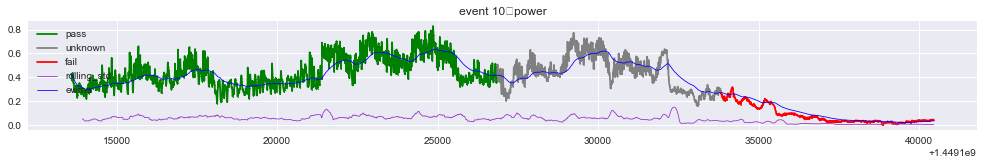

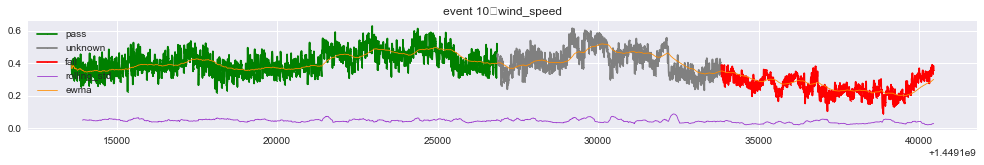

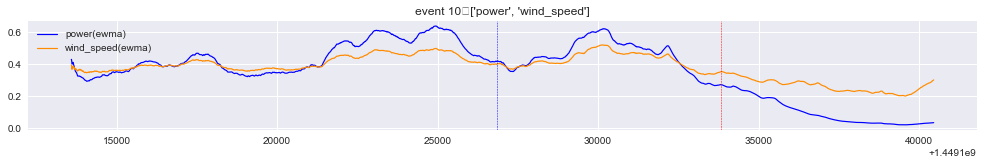

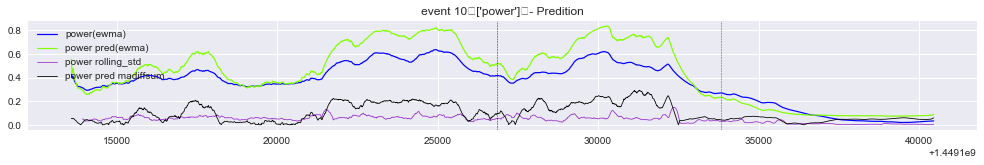

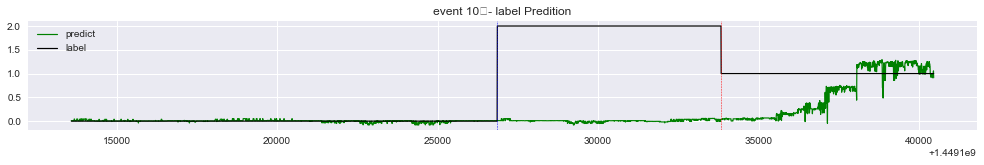

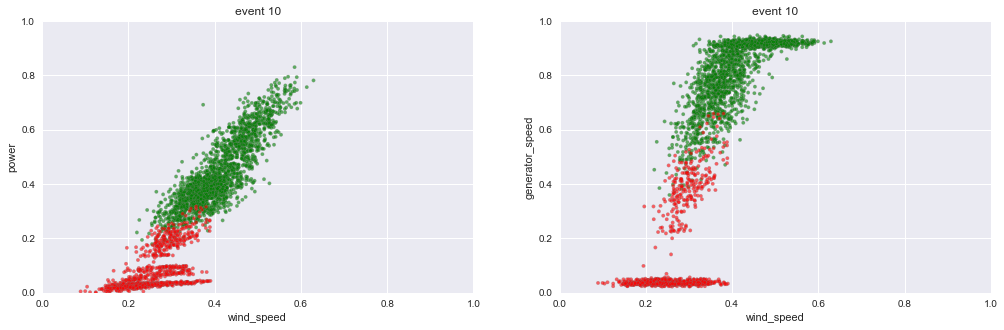

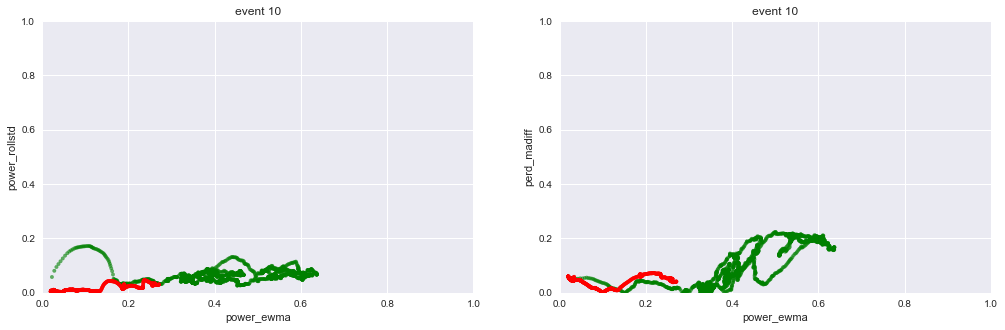

event id: 11
feature importance, predict: power


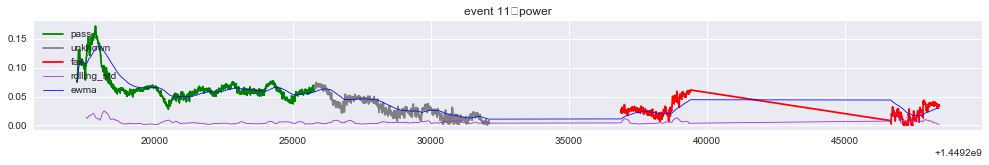

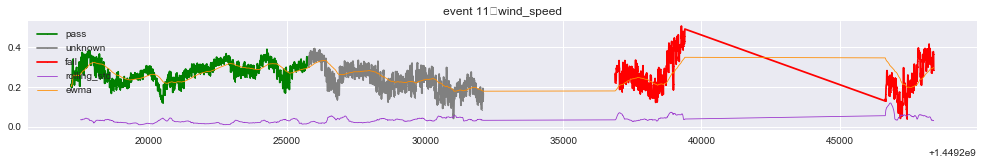

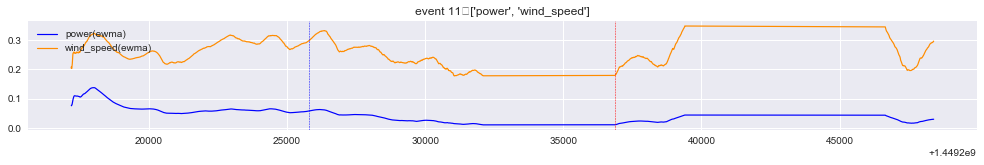

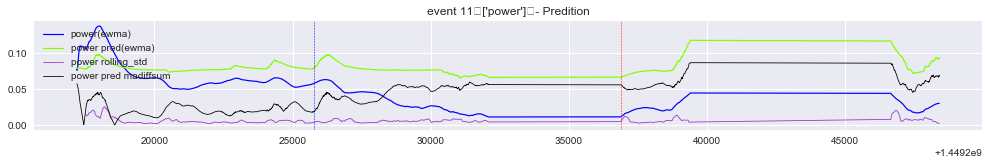

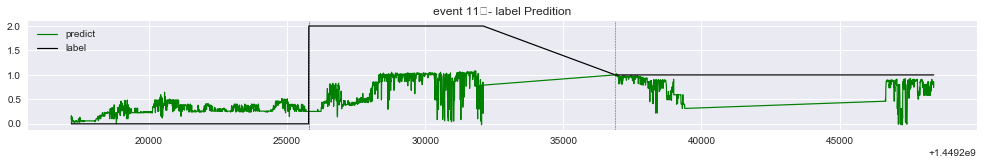

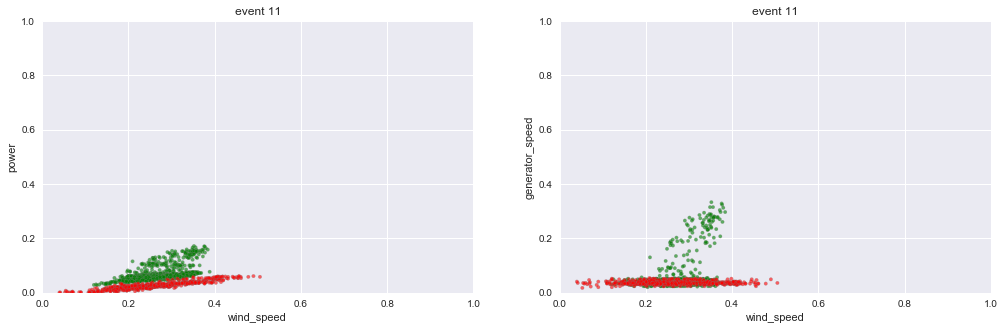

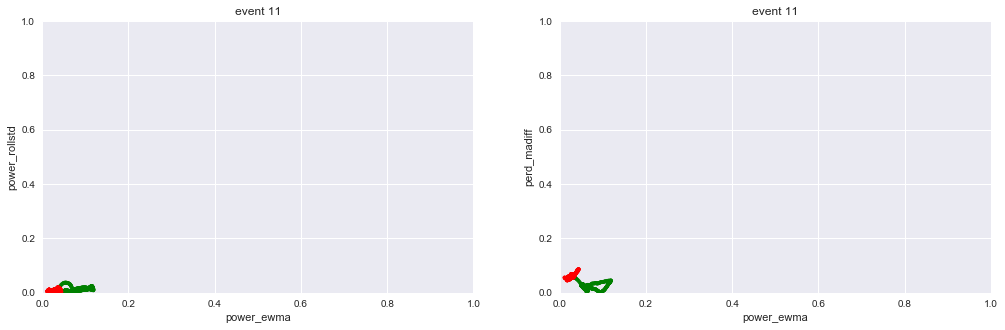

event id: 12
feature importance, predict: power


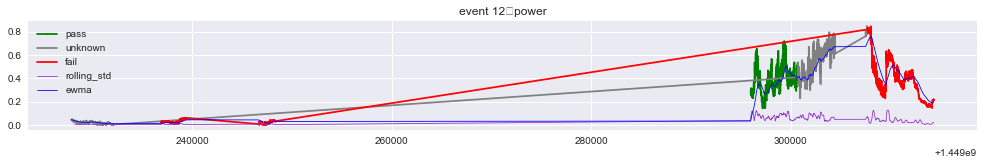

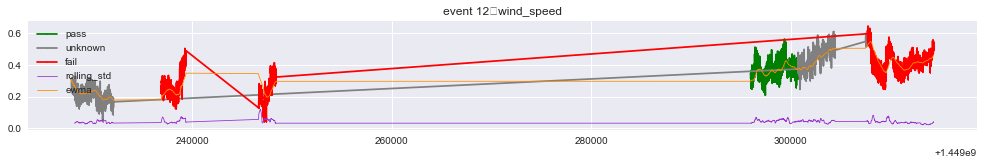

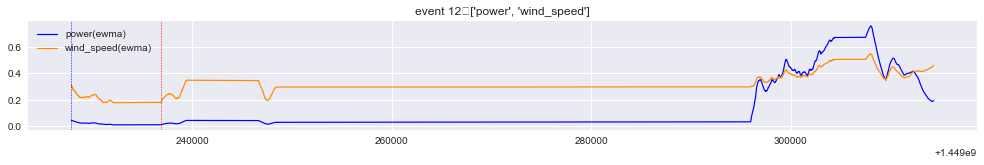

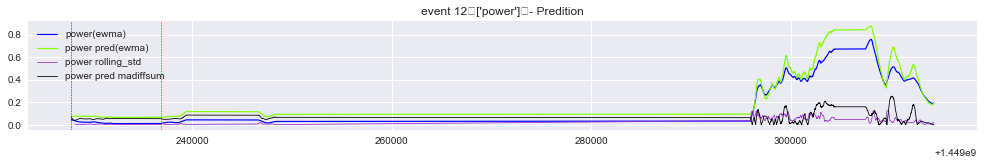

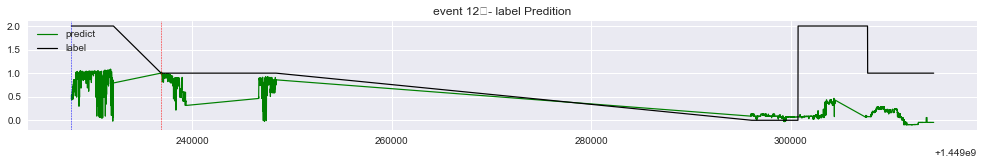

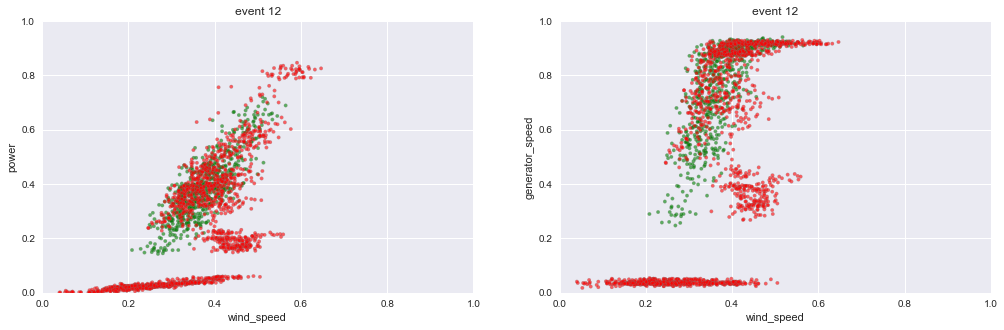

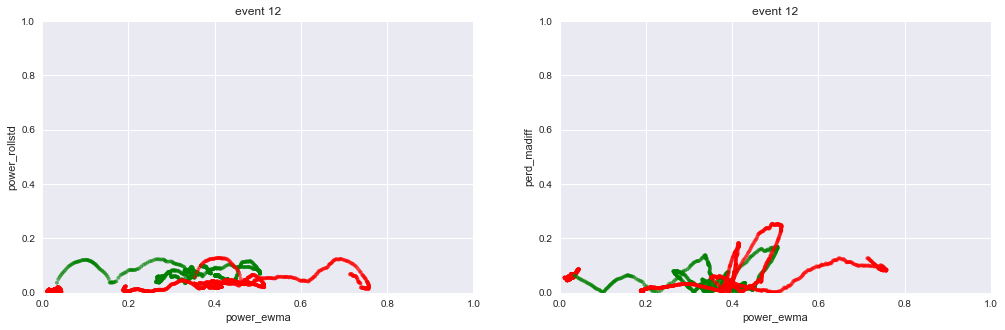

event id: 13
feature importance, predict: power


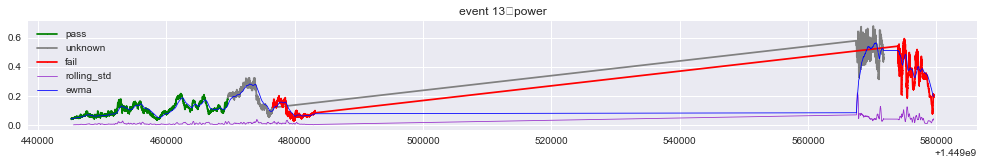

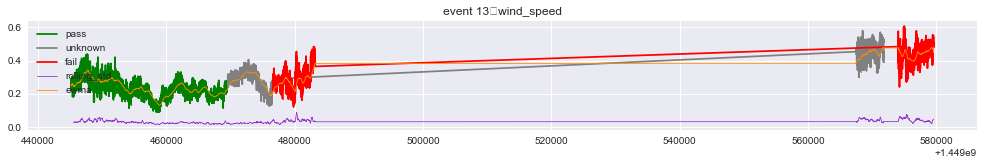

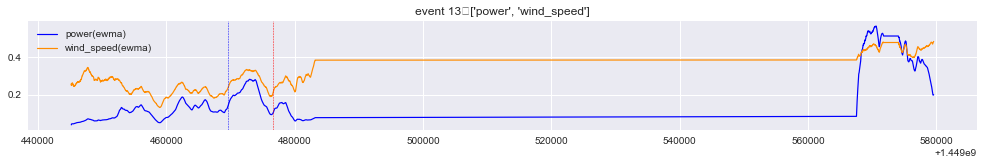

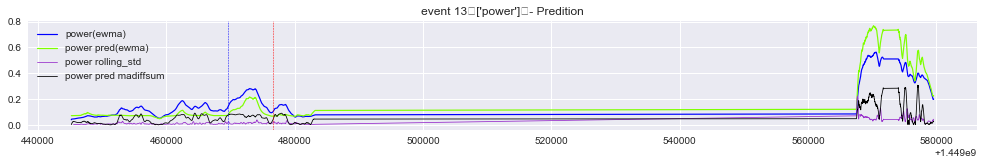

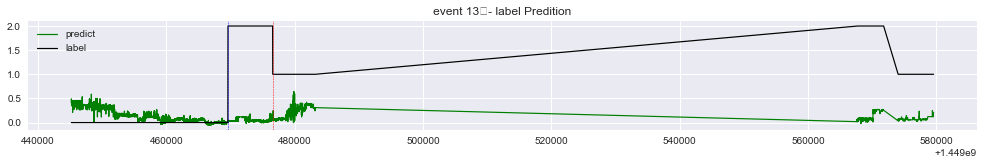

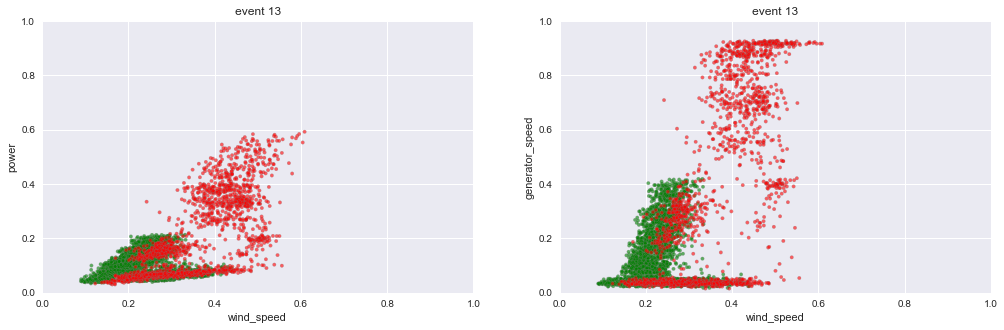

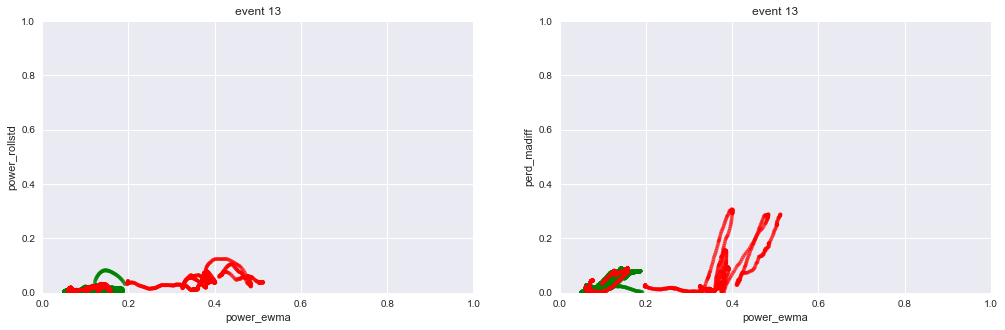

event id: 14
feature importance, predict: power


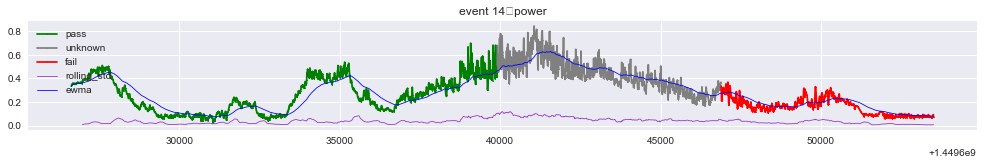

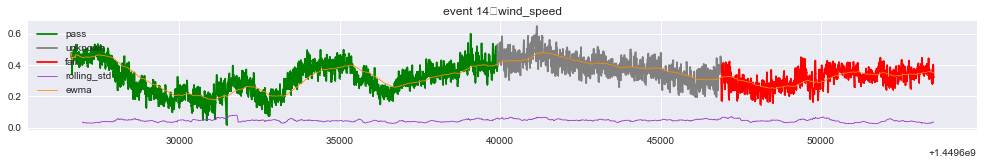

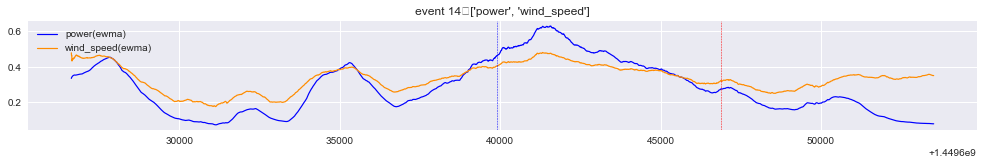

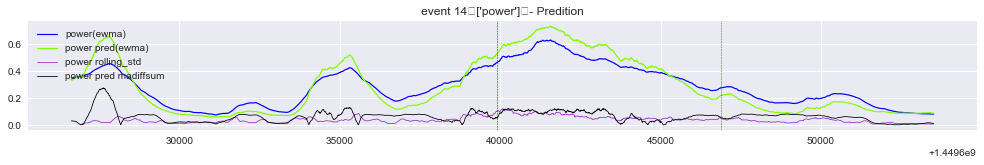

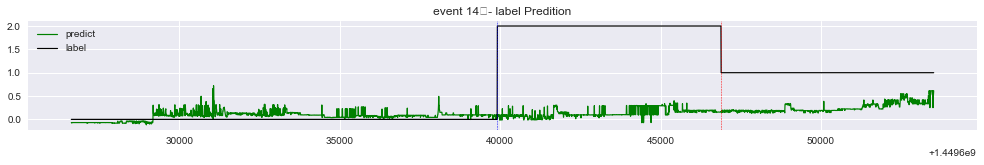

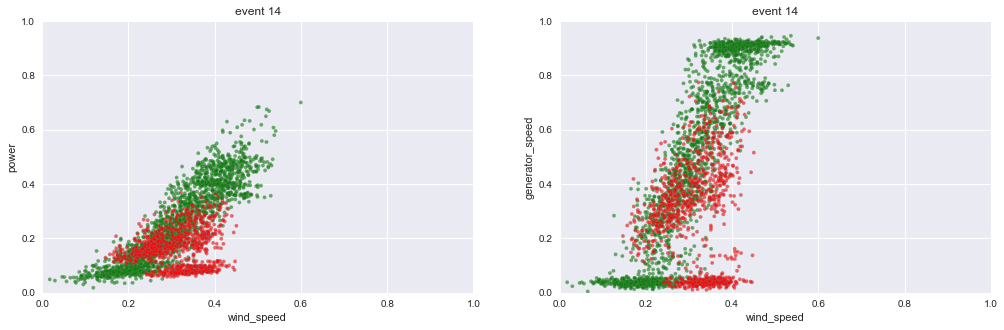

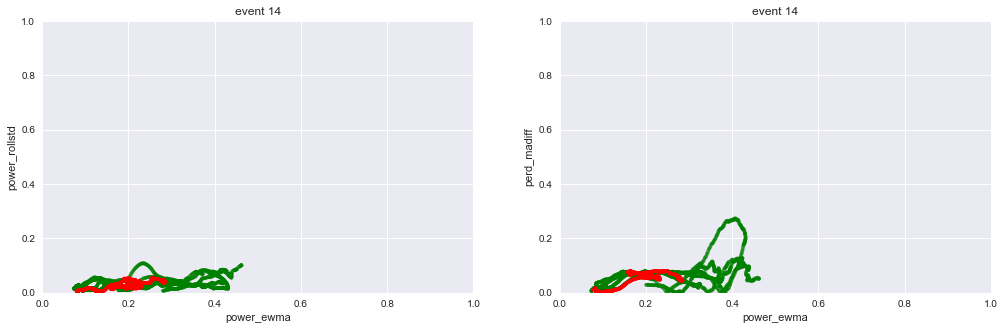

event id: 15
feature importance, predict: power


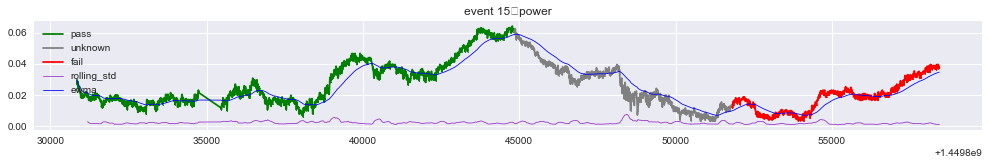

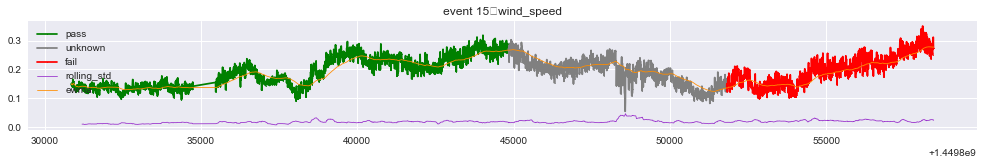

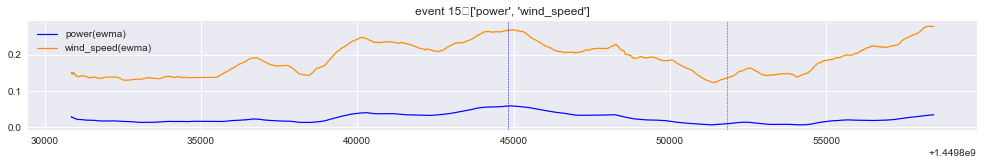

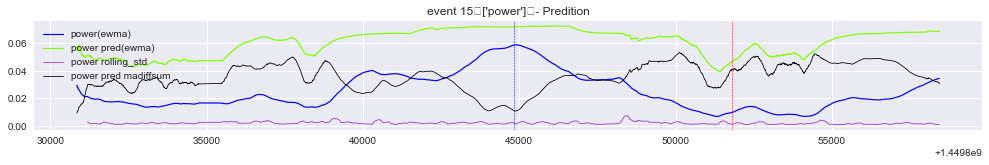

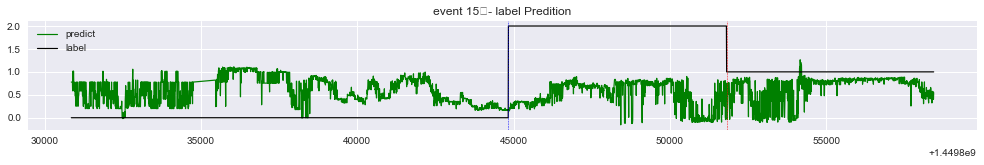

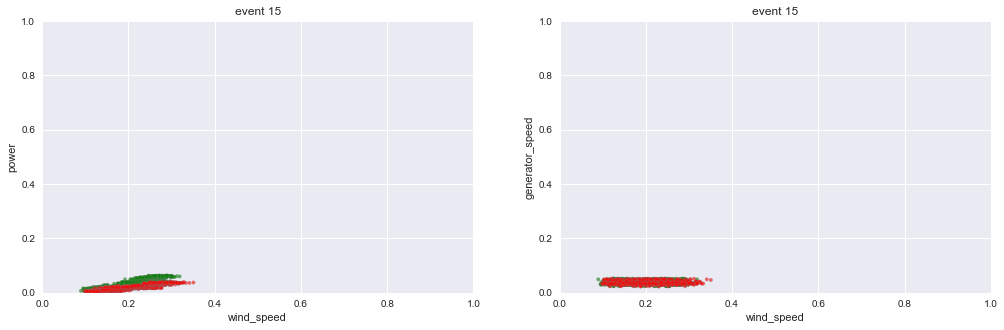

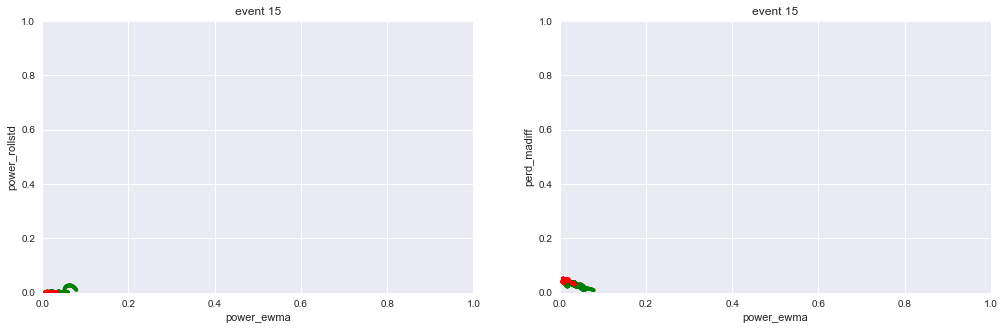

event id: 16
feature importance, predict: power


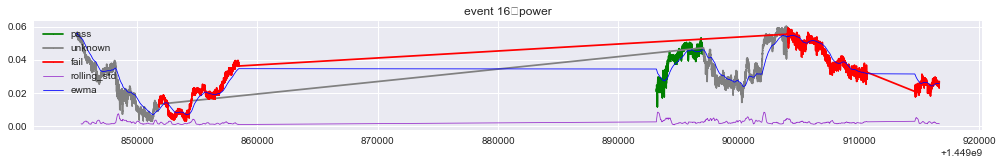

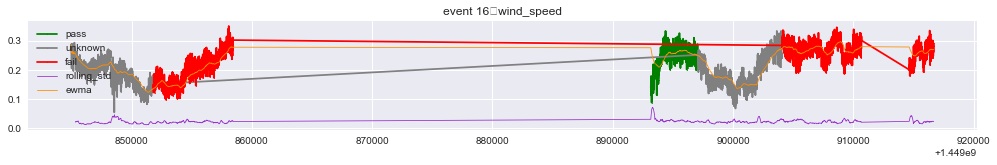

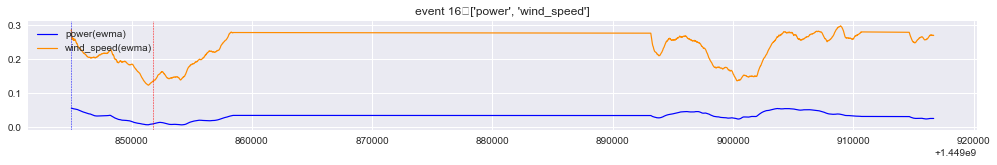

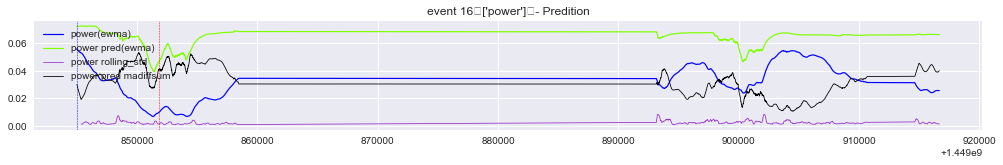

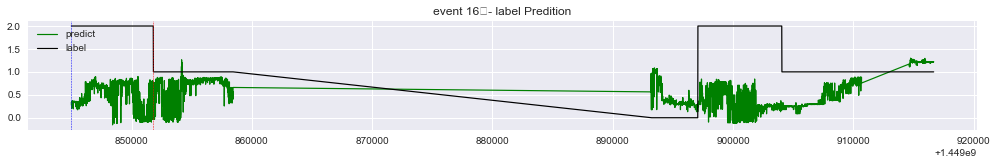

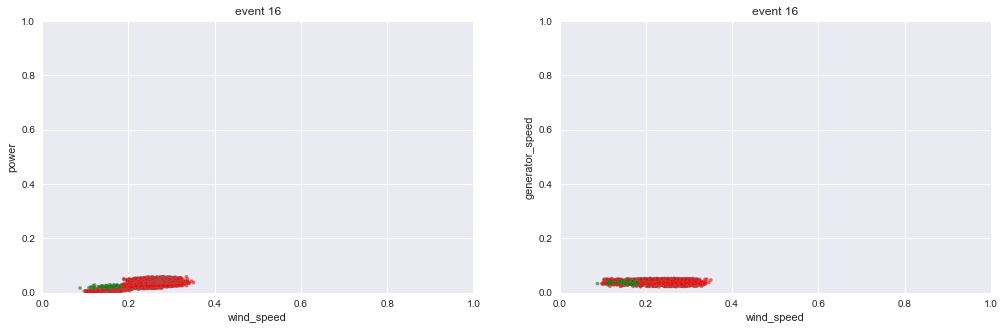

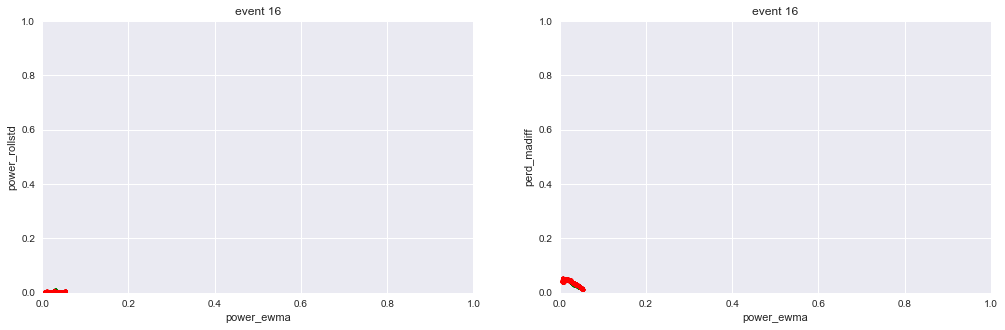

event id: 17
feature importance, predict: power


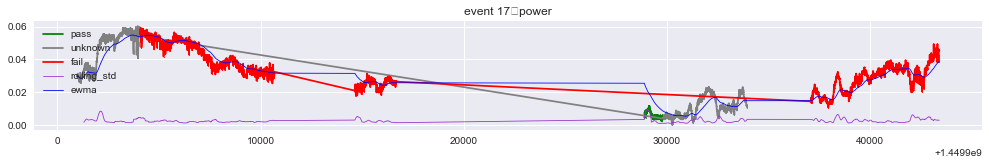

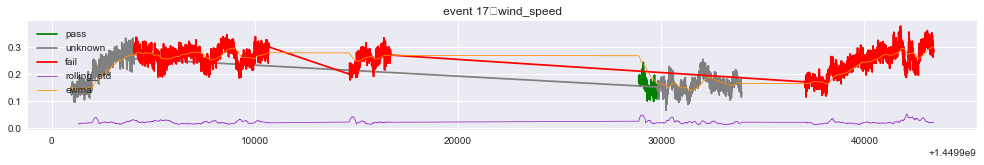

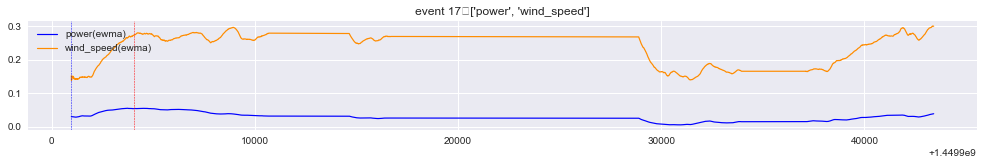

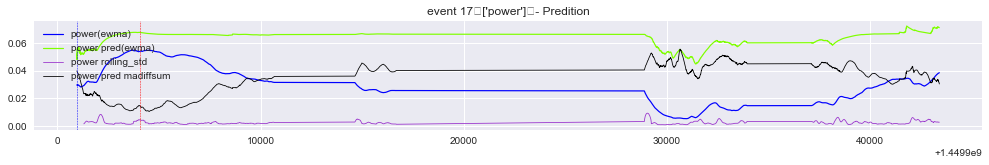

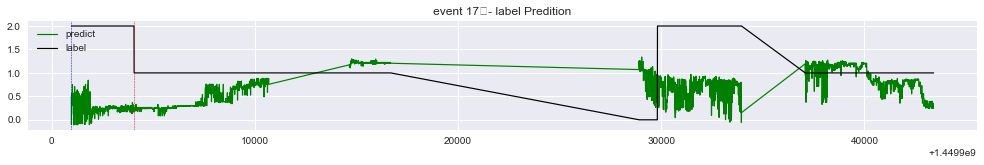

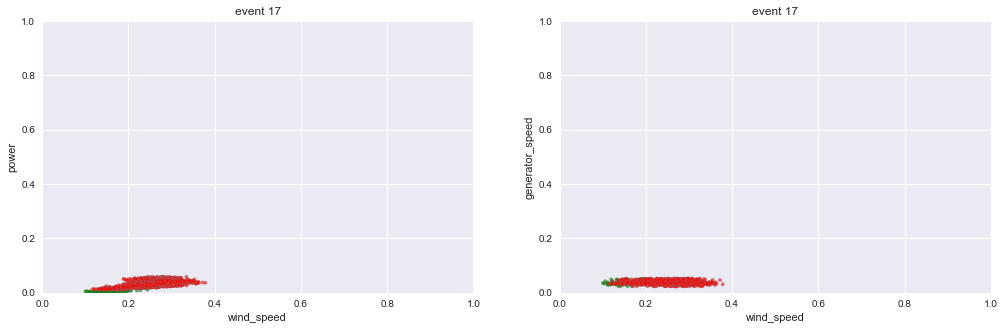

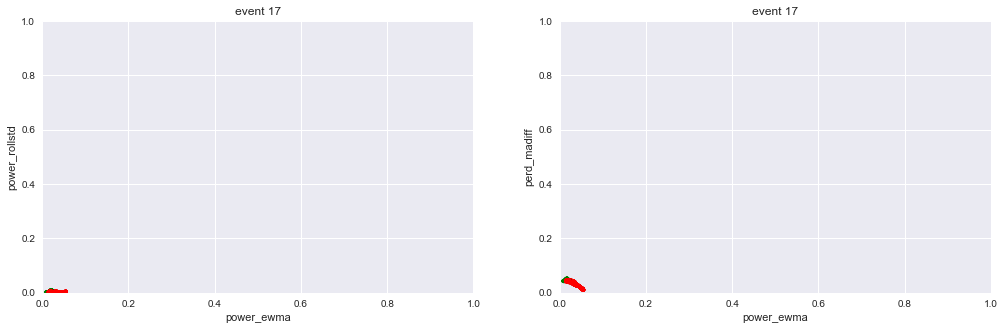

event id: 18
feature importance, predict: power


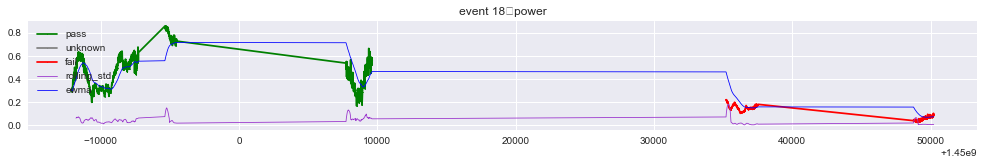

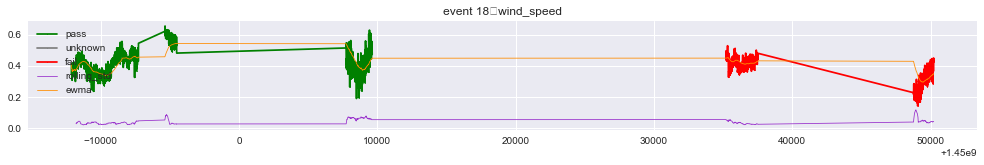

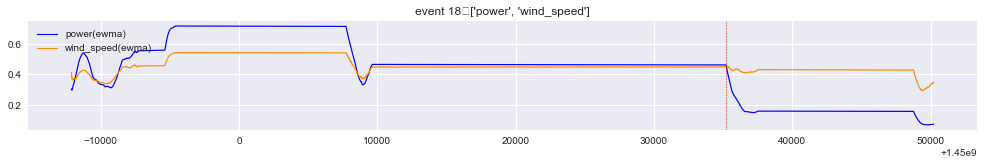

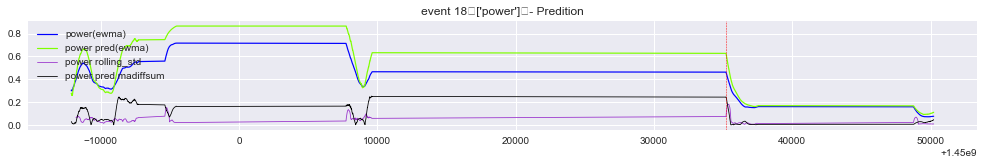

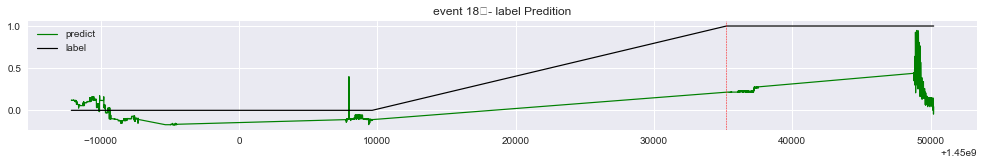

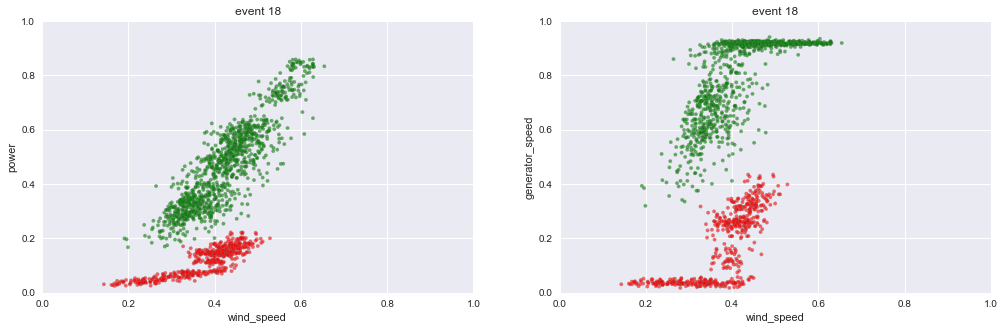

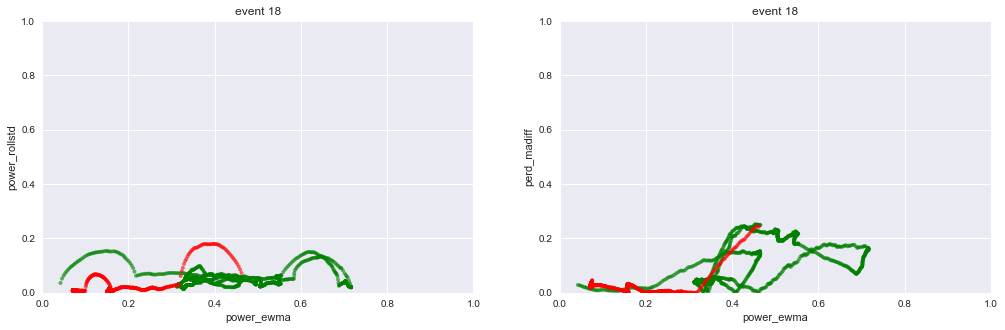

event id: 19
feature importance, predict: power


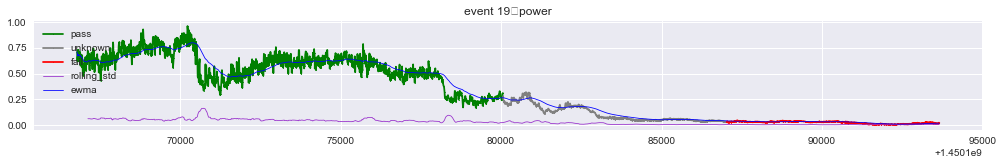

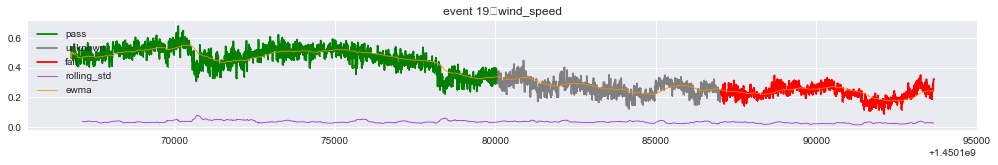

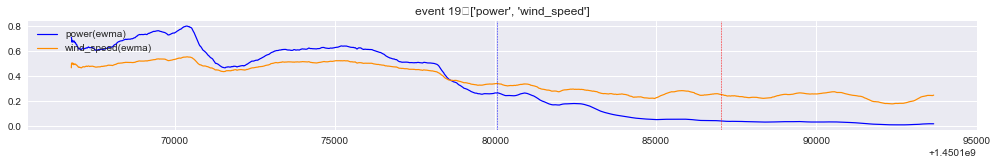

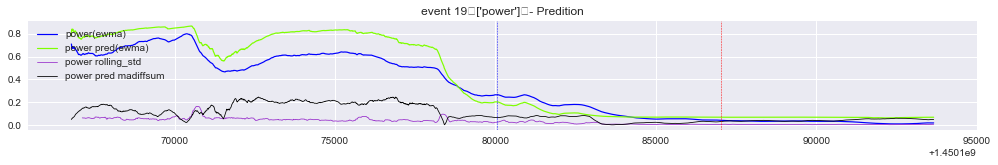

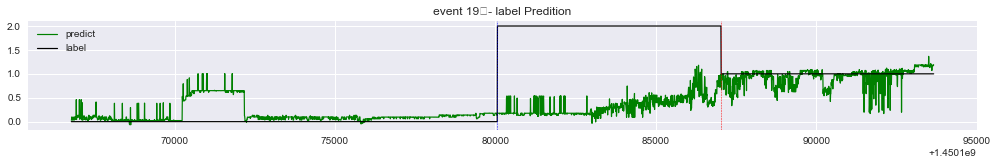

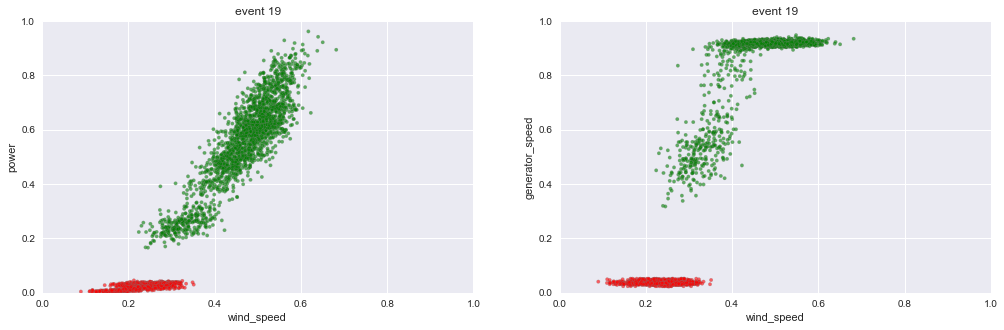

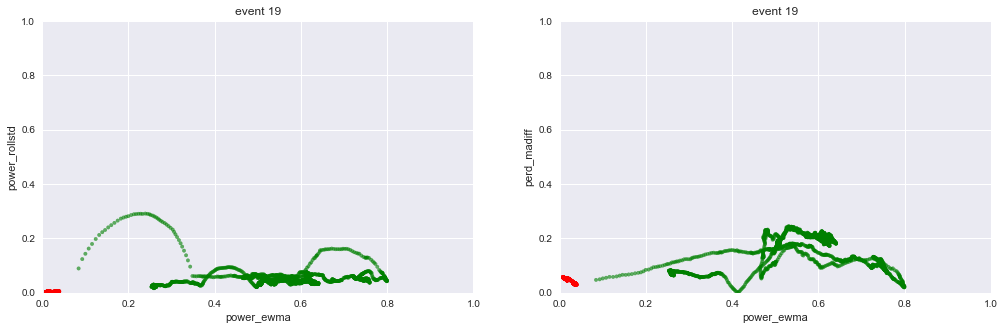

event id: 20
feature importance, predict: power


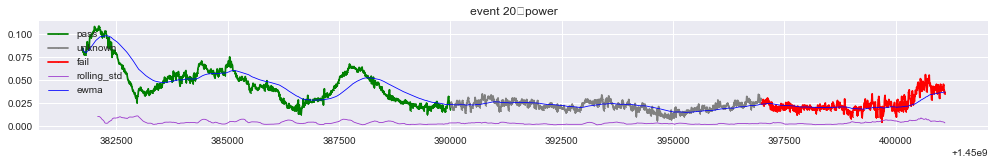

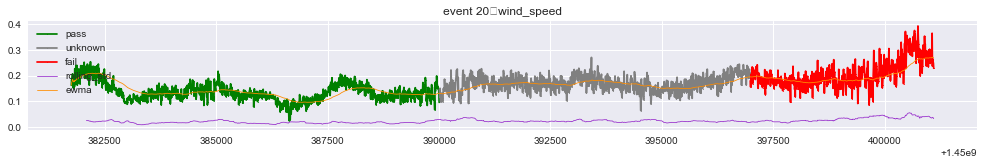

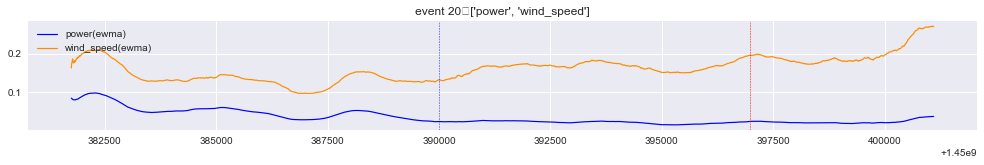

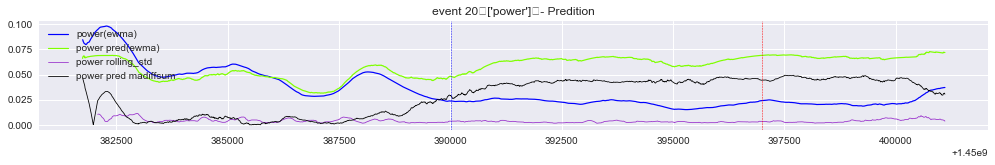

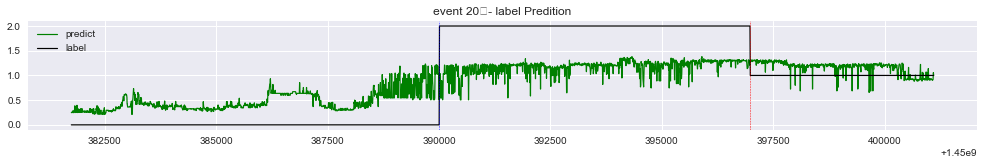

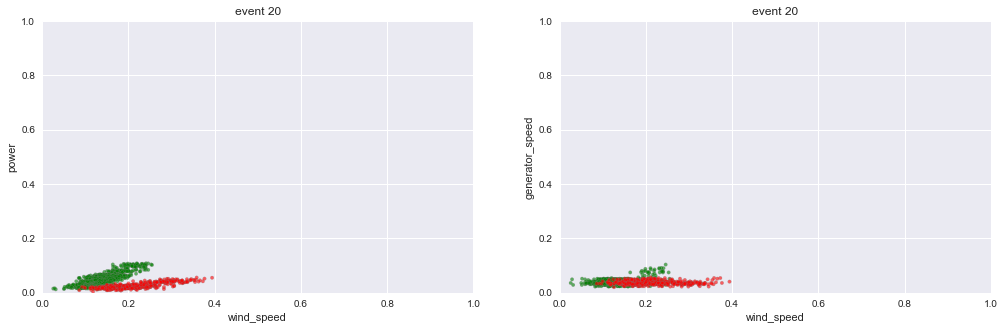

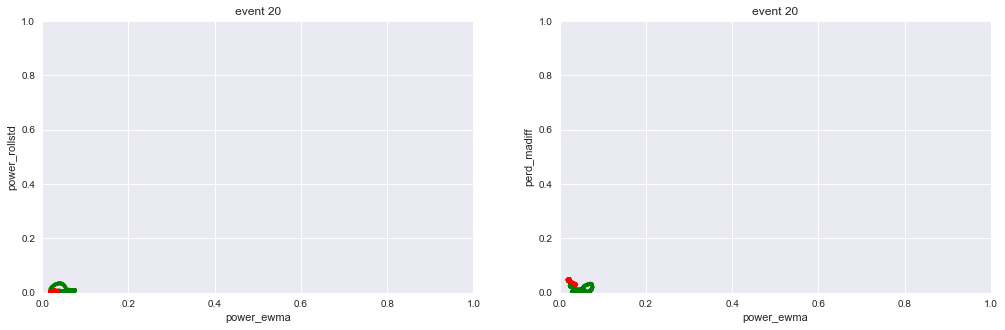

event id: 21
feature importance, predict: power


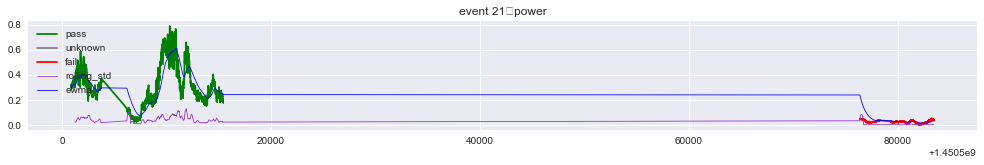

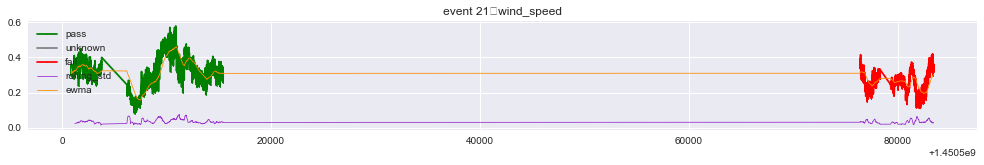

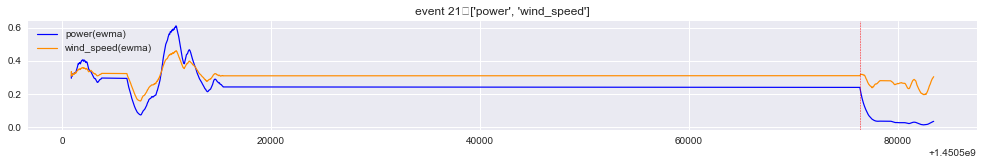

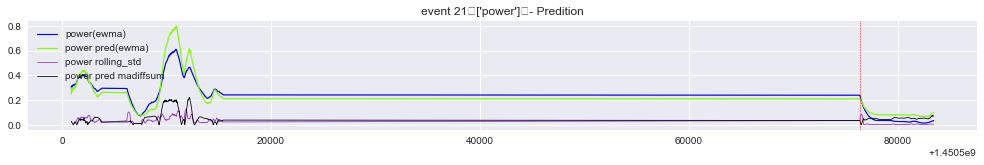

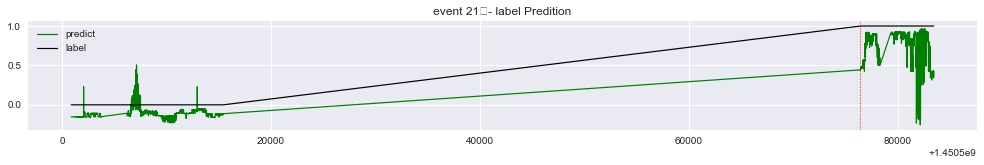

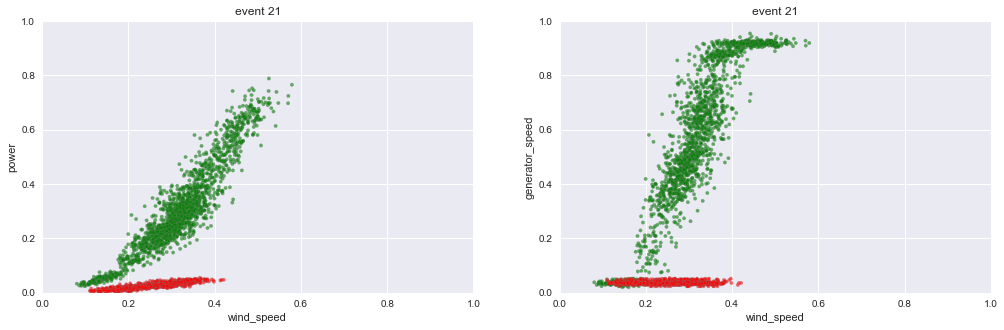

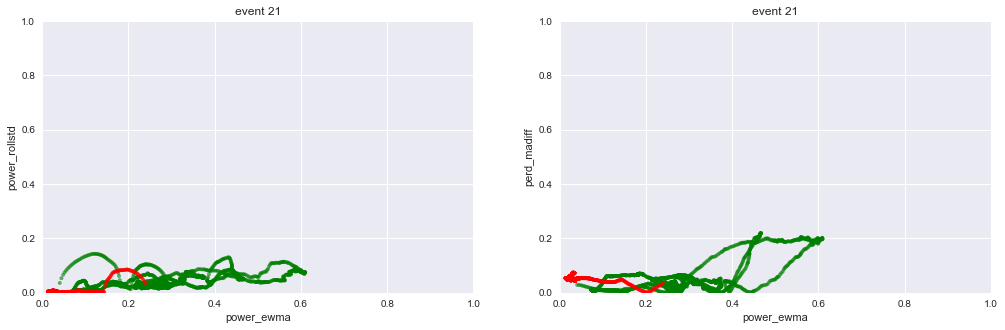

event id: 22
feature importance, predict: power


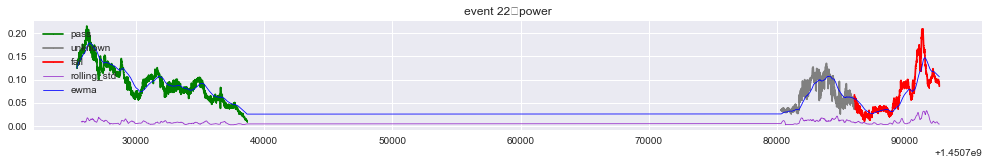

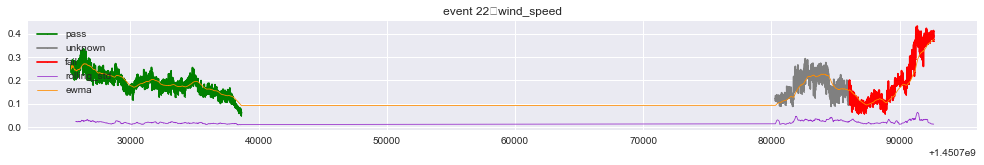

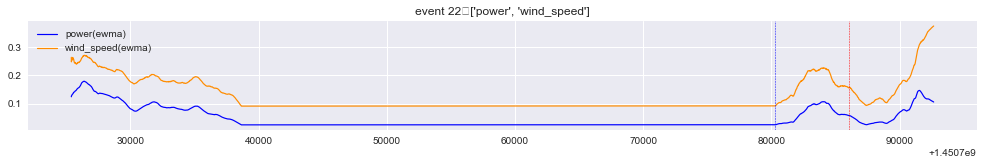

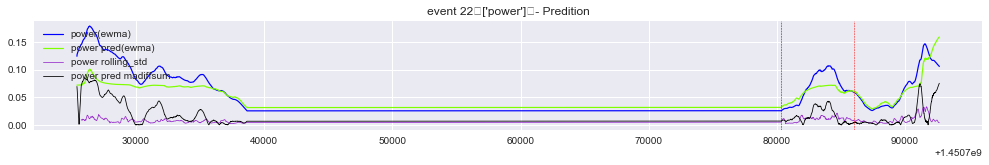

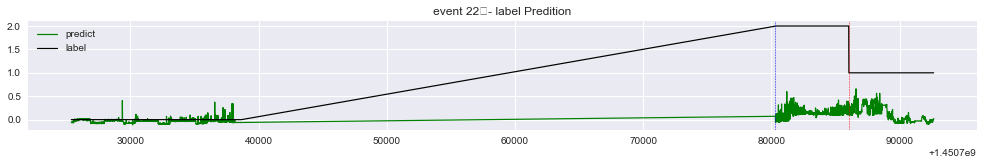

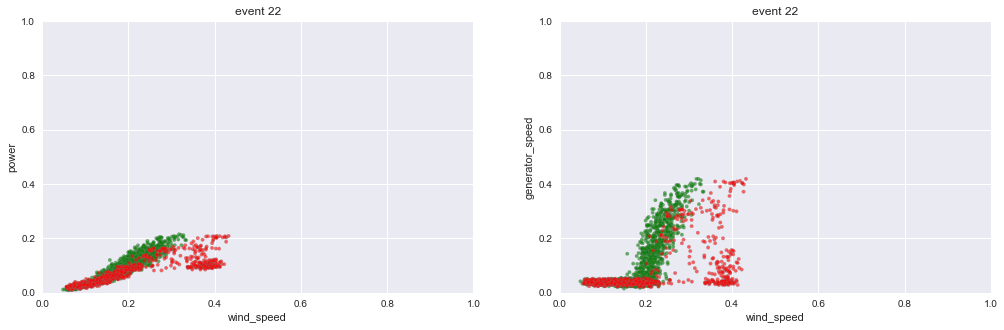

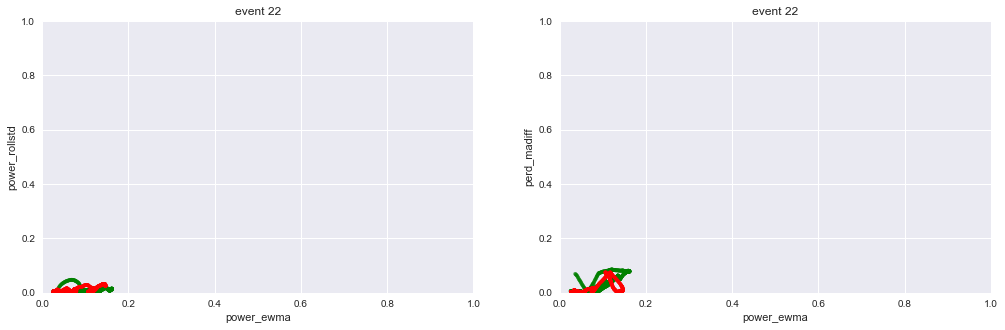

event id: 23
feature importance, predict: power


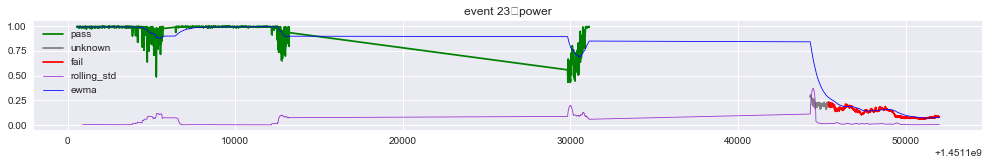

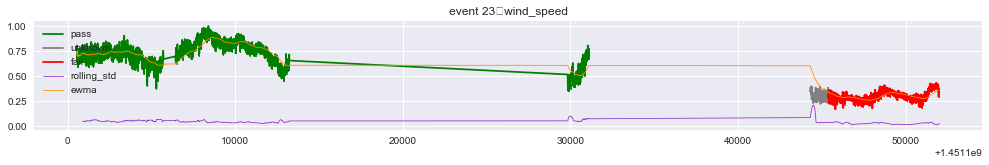

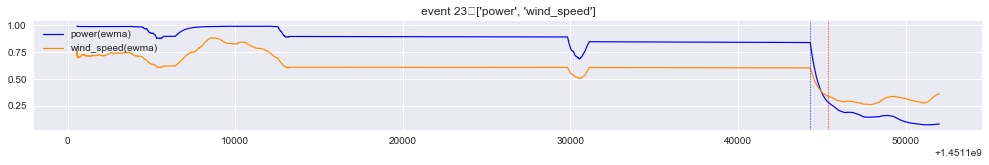

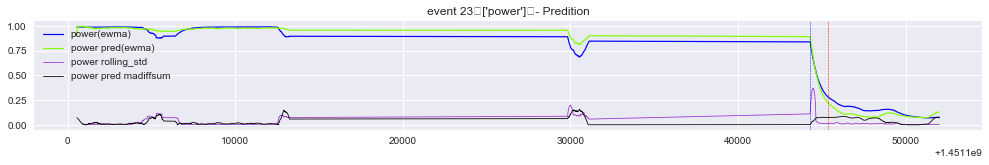

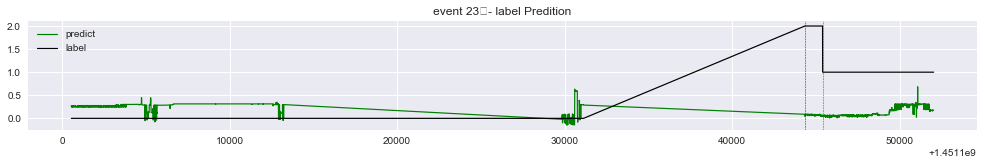

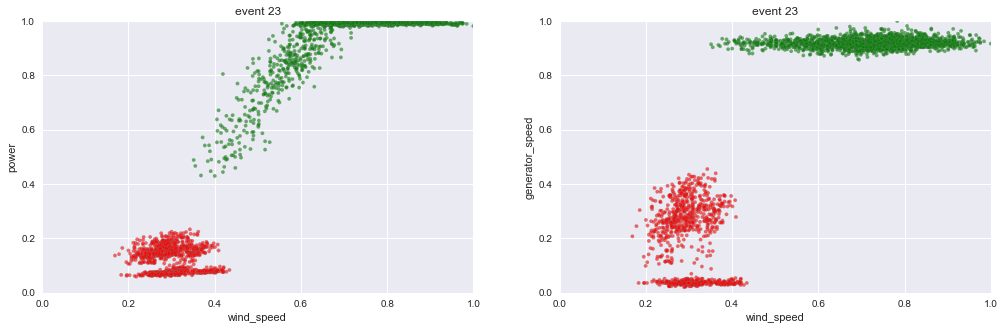

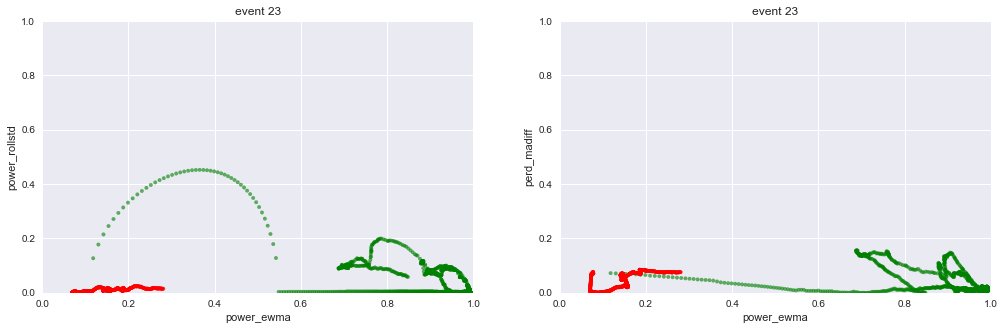

event id: 24
feature importance, predict: power


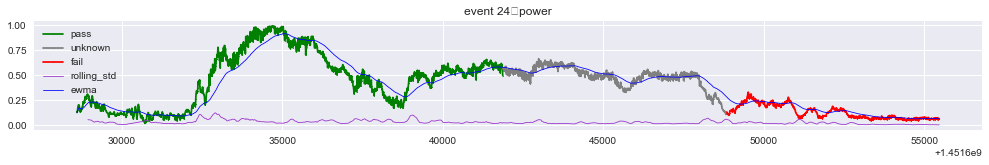

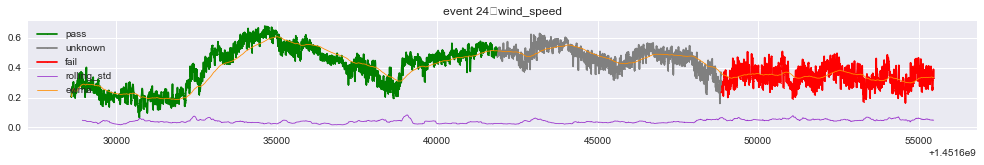

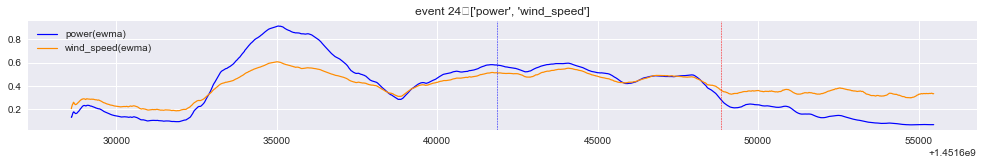

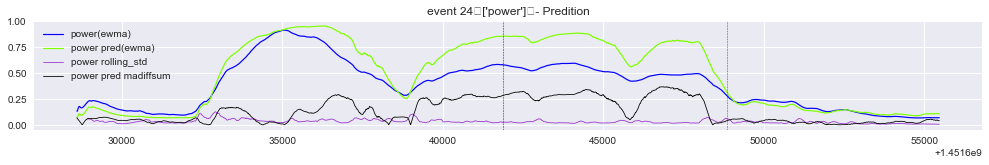

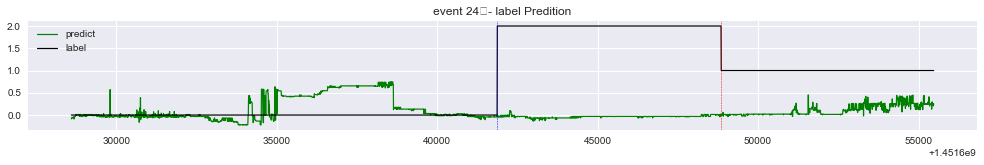

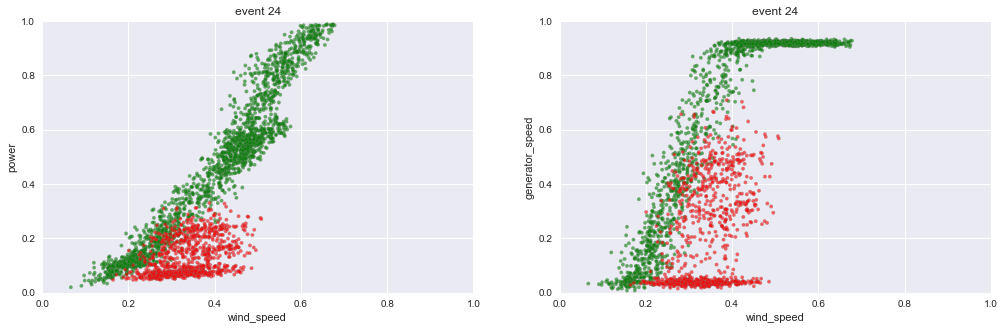

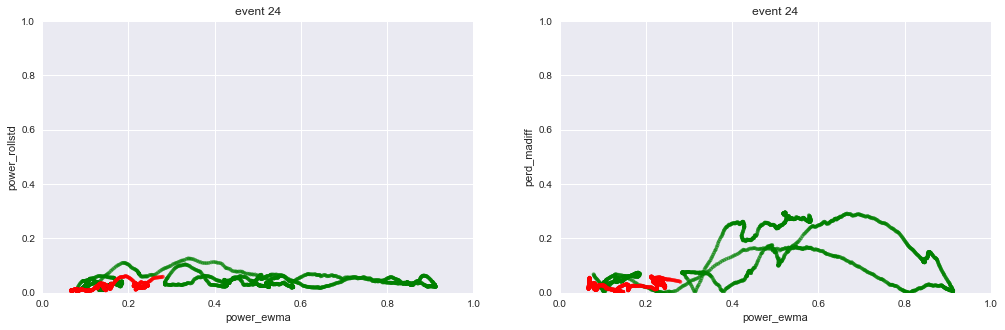

                     0                    1                    2   \
0       pitch1_moto_tmp       wind_direction      generator_speed   
1            wind_speed       pitch3_ng5_tmp           wind_speed   
2       generator_speed           wind_speed         yaw_position   
3        wind_direction      environment_tmp       wind_direction   
4               int_tmp  wind_direction_mean      environment_tmp   
5        pitch3_ng5_tmp              int_tmp      pitch1_moto_tmp   
6       pitch2_moto_tmp        pitch2_ng5_DC        pitch2_ng5_DC   
7          pitch3_angle      generator_speed       pitch3_ng5_tmp   
8             yaw_speed        pitch1_ng5_DC        pitch1_ng5_DC   
9       environment_tmp            yaw_speed  wind_direction_mean   
10      pitch3_moto_tmp         yaw_position      pitch2_moto_tmp   
11         pitch2_angle        pitch3_ng5_DC      pitch3_moto_tmp   
12        pitch1_ng5_DC       pitch2_ng5_tmp        pitch3_ng5_DC   
13  wind_direction_mean       pitc

In [380]:
exploration(data_trained=dat_scaled_M15_Complete, data_pred=dat_scaled_M15, ma=50)
